In [92]:
from keras.datasets import mnist
from sklearn.utils import shuffle
from models.VLAE import VLAE

vlae = VLAE(input_dim=(28, 28, 1), log_dir="", use_dropout=True, use_batch_norm=True, inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                                                                   inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                                                                   ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                                                                   ladder1_kernels_strides_featuremaps=[(5, 1, 64)],
                                                                   ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                                                                   gen2_num_units=[1024, 1024],
                                                                   gen1_num_units=[1024, 1024],
                                                                   gen0_kernels_strides_featuremaps=[(5, 2, 64), (5, 2, 1)], kernel_visualization_layer=1, num_samples=1, feature_map_layers=[1], inner_activation="ReLU", decay_rate=0, feature_map_reduction_factor=1, z_dims=[2,2,2])
vlae.load_weights("/Users/leo/Downloads/vlae_mnist_13_05_2020.h5")

In [105]:
from models.VAE import VAE

vae = VAE(input_dim=(128,128,1),encoder_conv_filters=[32, 64, 64, 64],encoder_conv_kernel_size=[3, 3, 3, 3], encoder_conv_strides=[2, 2, 2, 2],decoder_conv_t_filters=[64, 64, 32, 1],decoder_conv_t_kernel_size=[3, 3, 3, 3],decoder_conv_t_strides=[2, 2, 2, 2],z_dims=[2], log_dir="", feature_map_layers=[], kernel_visualization_layer=1, dropout_rate=0.3, use_batch_norm=True, use_dropout=True)
vae.load_weights("/Users/leo/Downloads/vanilla_vae.h5")

In [111]:
import keras
vlaegan = keras.models.load_model('/Users/leo/Downloads/vlae_gan_mnist.h5')
vlaegan_decoder = vlaegan.layers[-1]

In [112]:
vlaegan_decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()

array([[[1.1205673e-05, 0.0000000e+00, 0.0000000e+00, ...,
         8.9406967e-08, 8.9406967e-08, 5.6624413e-07],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [2.6822090e-07, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0520220e-05, 8.9406967e-08, 1.1920929e-07, ...,
         1.1920929e-07, 0.0000000e+00, 0.0000000e+00],
        [1.5482306e-04, 4.3809414e-06, 7.3313713e-06, ...,
         1.0788441e-05, 1.6689301e-06, 1.3709068e-05]],

       [[7.5608492e-05, 3.2782555e-07, 0.0000000e+00, ...,
         2.0861626e-07, 1.4901161e-07, 7.1525574e-07],
        [1.4901161e-07, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.000

In [113]:
import numpy as np
import scipy as sp
from utils.img_ops import resize_array
(_,_),(mnists,_) = mnist.load_data()
mnists = shuffle(mnists)
mnists = mnists.reshape((mnists.shape[0], -1))
mnist_mean = np.mean(mnists, axis=1)
mnist_sd = np.std(mnists, axis=1)
mnist_skew = sp.stats.skew(mnists, axis=1)
mnist_kurt = sp.stats.kurtosis(mnists, axis=1)

vlae_gens = vlae.decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()
vlae_gens = np.stack(vlae_gens)
vlae_gens *= 255.0
vlae_gens = vlae_gens.reshape(vlae_gens.shape[0], -1)
vlae_gens_mean = np.mean(vlae_gens, axis=1)
vlae_gens_sd = np.std(vlae_gens, axis=1)
vlae_gens_skew = sp.stats.skew(vlae_gens, axis=1)
vlae_gens_kurt = sp.stats.kurtosis(vlae_gens, axis=1)

vlaegan_gens = vlaegan_decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()
vlaegan_gens = np.stack(vlaegan_gens)
vlaegan_gens *= 255.0
vlaegan_gens = vlaegan_gens.reshape(vlaegan_gens.shape[0], -1)
vlaegan_gens_mean = np.mean(vlaegan_gens, axis=1)
vlaegan_gens_sd = np.std(vlaegan_gens, axis=1)
vlaegan_gens_skew = sp.stats.skew(vlaegan_gens, axis=1)
vlaegan_gens_kurt = sp.stats.kurtosis(vlaegan_gens, axis=1)

vae_gens = vae.decoder.predict(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000))
vae_gens = np.stack(vae_gens)
vae_gens *= 255.0
vae_gens = resize_array(vae_gens, (28,28), False)
vae_gens = vae_gens.reshape(vae_gens.shape[0], -1)
vae_gens_mean = np.mean(vae_gens, axis=1)
vae_gens_sd = np.std(vae_gens, axis=1)
vae_gens_skew = sp.stats.skew(vae_gens, axis=1)
vae_gens_kurt = sp.stats.kurtosis(vae_gens, axis=1)

In [114]:
import scipy as sp

print("vae mean",sp.stats.wilcoxon(mnist_mean, vae_gens_mean))
print("vae sd",sp.stats.wilcoxon(mnist_sd, vae_gens_sd))
print("vae skew",sp.stats.wilcoxon(mnist_skew, vae_gens_skew))
print("vae kurt",sp.stats.wilcoxon(mnist_kurt, vae_gens_kurt))
print('---')
print("vlae mean",sp.stats.wilcoxon(mnist_mean, vlae_gens_mean))
print("vlae sd",sp.stats.wilcoxon(mnist_sd, vlae_gens_sd))
print("vlae skew",sp.stats.wilcoxon(mnist_skew, vlae_gens_skew))
print("vlae kurt",sp.stats.wilcoxon(mnist_kurt, vlae_gens_kurt))
print('---')
print("vlaegan mean",sp.stats.wilcoxon(mnist_mean, vlaegan_gens_mean))
print("vlaegan sd",sp.stats.wilcoxon(mnist_sd, vlaegan_gens_sd))
print("vlaegan skew",sp.stats.wilcoxon(mnist_skew, vlaegan_gens_skew))
print("vlaegan kurt",sp.stats.wilcoxon(mnist_kurt, vlaegan_gens_kurt))

vae mean WilcoxonResult(statistic=9338966.0, pvalue=0.0)
vae sd WilcoxonResult(statistic=7245908.0, pvalue=0.0)
vae skew WilcoxonResult(statistic=3335806.0, pvalue=0.0)
vae kurt WilcoxonResult(statistic=5199530.0, pvalue=0.0)
---
vlae mean WilcoxonResult(statistic=18682508.0, pvalue=3.133676602200257e-106)
vlae sd WilcoxonResult(statistic=5734198.0, pvalue=0.0)
vlae skew WilcoxonResult(statistic=22427295.0, pvalue=4.658556090845649e-19)
vlae kurt WilcoxonResult(statistic=24517103.0, pvalue=0.0926971969909884)
---
vlaegan mean WilcoxonResult(statistic=22063458.0, pvalue=2.426205379442575e-24)
vlaegan sd WilcoxonResult(statistic=21620770.0, pvalue=1.083423140885254e-31)
vlaegan skew WilcoxonResult(statistic=24428415.0, pvalue=0.04675203993072458)
vlaegan kurt WilcoxonResult(statistic=24567749.0, pvalue=0.1320906132350454)


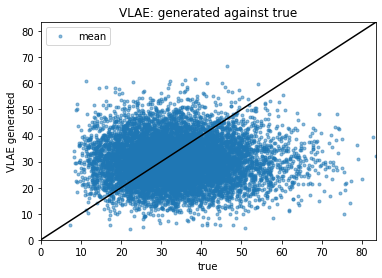

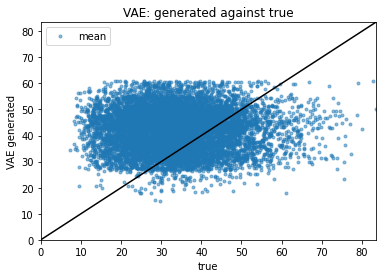

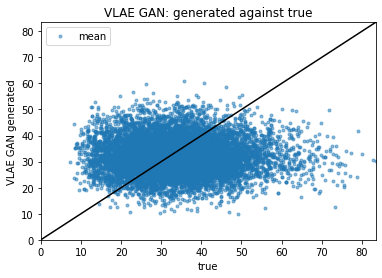

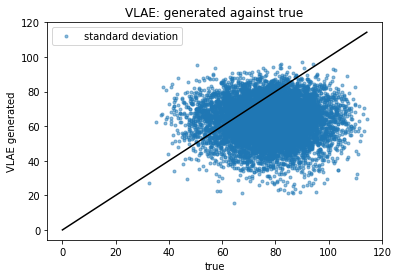

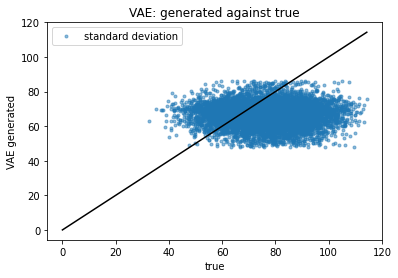

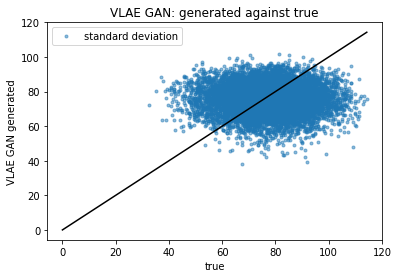

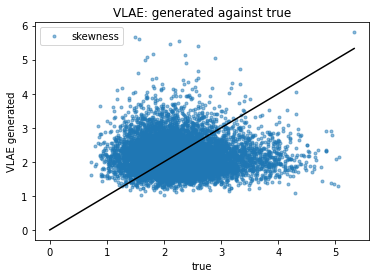

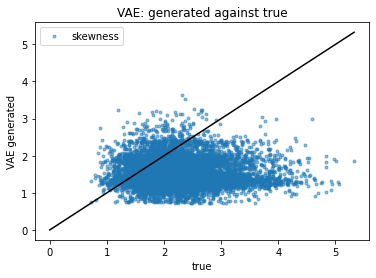

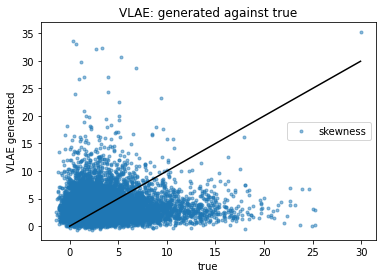

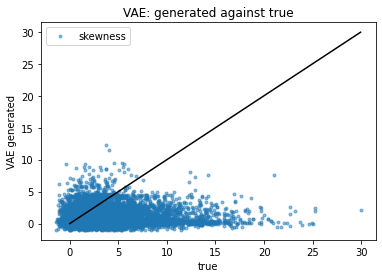

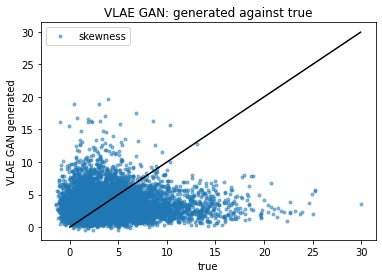

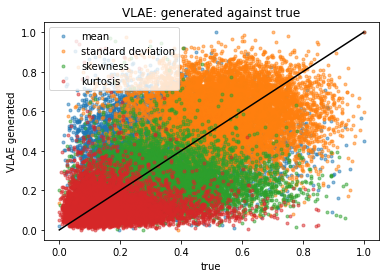

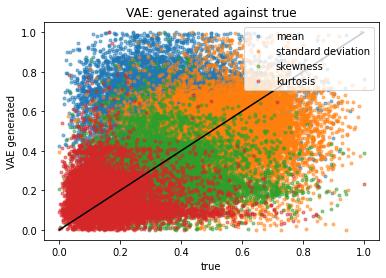

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

def _clamp(x):
    return (x - x.min())/(x.max() - x.min())

x = np.array([1, 2, 3, 4, 5])
y = np.power(x, 2) # Effectively y = x**2
maxx = max([mnist_mean.max(), mnist_sd.max(), vlae_gens_mean.max(), vlae_gens_sd.max()])

plt.plot((mnist_mean), (vlae_gens_mean), '.', label='mean', alpha=0.5)
mmax = max(mnist_mean.max(),vlae_gens_mean.max())
plt.plot([0.0, mmax], [0.0, mmax], c='k')
plt.xlim(0, mmax)
plt.ylim(0, mmax)
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_mean), (vae_gens_mean), '.', label='mean', alpha=0.5)
mmax = max(mnist_mean.max(),vae_gens_mean.max())
plt.plot([0.0, mmax], [0.0, mmax], c='k')
plt.xlim(0, mmax)
plt.ylim(0, mmax)
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_mean), (vlaegan_gens_mean), '.', label='mean', alpha=0.5)
mmax = max(mnist_mean.max(),vlaegan_gens_mean.max())
plt.plot([0.0, mmax], [0.0, mmax], c='k')
plt.xlim(0, mmax)
plt.ylim(0, mmax)
plt.legend()
plt.title('VLAE GAN: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE GAN generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_sd), (vlae_gens_sd), '.', label='standard deviation', alpha=0.5)
plt.plot([0.0, mnist_sd.max()], [0.0, mnist_sd.max()], c='k')
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_sd), (vae_gens_sd), '.', label='standard deviation', alpha=0.5)
plt.plot([0.0, mnist_sd.max()], [0.0, mnist_sd.max()], c='k')
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_sd), (vlaegan_gens_sd), '.', label='standard deviation', alpha=0.5)
plt.plot([0.0, mnist_sd.max()], [0.0, mnist_sd.max()], c='k')
plt.legend()
plt.title('VLAE GAN: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE GAN generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()


plt.plot((mnist_skew), (vlae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_skew.max()], [0.0, mnist_skew.max()], c='k')
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_skew), (vae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_skew.max()], [0.0, mnist_skew.max()], c='k')
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_kurt), (vlae_gens_kurt), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_kurt.max()], [0.0, mnist_kurt.max()], c='k')
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_kurt), (vae_gens_kurt), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_kurt.max()], [0.0, mnist_kurt.max()], c='k')
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_kurt), (vlaegan_gens_kurt), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_kurt.max()], [0.0, mnist_kurt.max()], c='k')
plt.legend()
plt.title('VLAE GAN: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE GAN generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot(_clamp(mnist_mean), _clamp(vlae_gens_mean), '.', label='mean', alpha=0.5)
plt.plot(_clamp(mnist_sd), _clamp(vlae_gens_sd), '.', label="standard deviation", alpha=0.5)
plt.plot(_clamp(mnist_skew), _clamp(vlae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot(_clamp(mnist_kurt), _clamp(vlae_gens_kurt), '.', label="kurtosis", alpha=0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], c='k')

plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot(_clamp(mnist_mean), _clamp(vae_gens_mean), '.', label='mean', alpha=0.5)
plt.plot(_clamp(mnist_sd), _clamp(vae_gens_sd), '.', label="standard deviation", alpha=0.5)
plt.plot(_clamp(mnist_skew), _clamp(vae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot(_clamp(mnist_kurt), _clamp(vae_gens_kurt), '.', label="kurtosis", alpha=0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], c='k')

plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

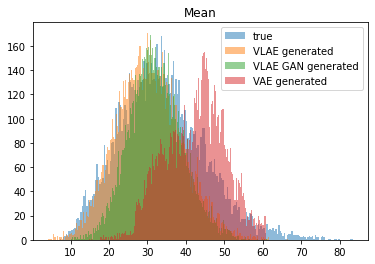

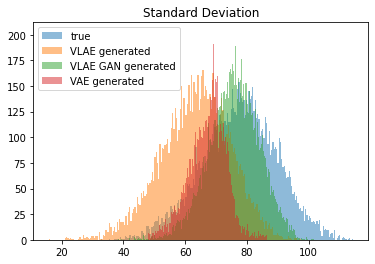

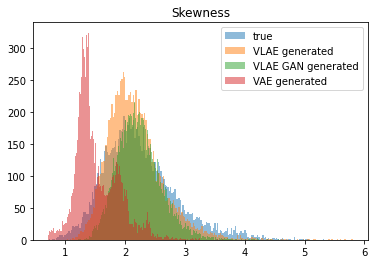

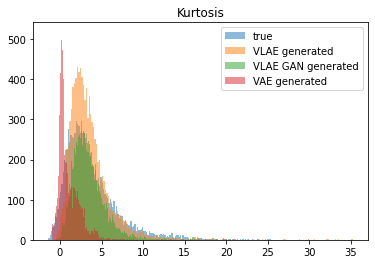

In [117]:
bins = 200
plt.title("Mean")
plt.hist(mnist_mean, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_mean, bins, alpha=0.5, label="VLAE generated")
plt.hist(vlaegan_gens_mean, bins, alpha=0.5, label="VLAE GAN generated")
plt.hist(vae_gens_mean, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()
plt.title("Standard Deviation")
plt.hist(mnist_sd, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_sd, bins, alpha=0.5, label="VLAE generated")
plt.hist(vlaegan_gens_sd, bins, alpha=0.5, label="VLAE GAN generated")
plt.hist(vae_gens_sd, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()
plt.title("Skewness")
plt.hist(mnist_skew, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_skew, bins, alpha=0.5, label="VLAE generated")
plt.hist(vlaegan_gens_skew, bins, alpha=0.5, label="VLAE GAN generated")
plt.hist(vae_gens_skew, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()
plt.title("Kurtosis")
plt.hist(mnist_kurt, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_kurt, bins, alpha=0.5, label="VLAE generated")
plt.hist(vlaegan_gens_kurt, bins, alpha=0.5, label="VLAE GAN generated")
plt.hist(vae_gens_kurt, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()

In [26]:
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.datasets import mnist
import numpy as np

(x_train, _), (_, _) = mnist.load_data()
preds_train = vlae.decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=60000) for _ in range(3)]).squeeze()
x_train = np.concatenate([x_train, preds_train], axis=0)
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.concatenate([np.zeros((60000)), np.ones((60000))])
x_train, y_train = shuffle(x_train, y_train)

x = inpt = Input(shape=(28,28,1))
x = Conv2D(batch_input_shape=(28,28,1), filters=20, kernel_size=5)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(filters=20, kernel_size=3)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(100)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = outpt = Dense(1, activation='sigmoid')(x)

model = Model(inpt, outpt)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 20)        520       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 24, 24, 20)        0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 24, 24, 20)        80        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 20)        3620      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 22, 22, 20)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 22, 22, 20)        80        
__________

In [7]:
(_, _), (x_test, _) = mnist.load_data()
preds_test = vlae.decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()
x_test = np.concatenate([x_test, preds_test], axis=0)
x_test = np.expand_dims(x_test, axis=-1)
y_test = np.concatenate([np.zeros((10000)), np.ones((10000))])
x_test, y_test = shuffle(x_test, y_test)
# model.evaluate(x_test, y_test)



In [6]:
from models.model_abstract import ModelWrapper

def avg_gen_for_a(a: np.ndarray, num_zs: int, num_samples: int):

    def avg_gen_for_a_and_z(z_idx: int):
        zs = [np.expand_dims(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=num_samples), 0) for _ in range(num_zs)]
        zs[z_idx] = np.array([a for _ in range(num_samples)])
        zs[z_idx] = zs[z_idx].swapaxes(0,1)
        zs = np.concatenate(zs)
        gens = vlae.decoder.predict(list(zs)) * 255.0
        #gens = [vlae.decoder.predict([zs[j, i] for j in range(3)] for i in range(num_samples))]
        return np.mean(gens, axis=0)

    return np.array([avg_gen_for_a_and_z(z_idx) for z_idx in range(num_zs)])

num_as = 100
num_samples = 300
a_s = np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=num_as)
gens = np.array([avg_gen_for_a(np.expand_dims(a,0), 3, num_samples) for a in a_s])

In [ ]:
from utils.statistic import cross_cumulants
import matplotlib
%matplotlib inline
print("a")
for i in range(28):
    for j in range(28):
        pxl = gens[:,0,i,j,0]
        pxl = np.stack([pxl, pxl], axis=1)
        #print(cross_cumulants(pxl))
        
rows = 28
cols = 28
fig1, ax1 = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(rows, cols))
fig2, ax2 = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True, figsize=(rows, cols))
k=0
vmin = np.inf
vmax = -np.inf
ccs = {}
for i in range(28):
    ccs[i] = {}
    for j in range(28):
        g1 = np.copy(gens[:,0,i,j,0])
        g2 = np.copy(gens[:,1,i,j,0])
        cc = cross_cumulants(np.stack((g1, g2),axis=-1))
        ccs[i][j] = cc
        c_min, c_max = np.min(cc), np.max(cc)
        if c_min < vmin: vmin = c_min
        if c_max > vmax: vmax = c_max
        #print(np.max(g1), np.max(g2))
        row = k//rows
        col = k%cols
        #print("k {} row {} col {}".format(k, row, col))
        #ax1[row,col].plot(g1,g2,'.')
k=0
from matplotlib import cm
viridis = cm.get_cmap('viridis', 256)
for i in range(28):
    for j in range(28):
        row = k//(rows)
        col = k%cols
        ax2[row,col].text(x=0,y=0,s="{:.1E}".format(ccs[i][j]))
        ax2[row,col].set_facecolor(viridis((ccs[i][j]-vmin)/vmax))
        k+=1
fig1.xlabel = "Mean pixel itensity first component"
fig2.xlabel = "Mean pixel itensity first component"
fig1.ylabel = "Mean pixel intensity second component"
fig2.ylabel = "Mean pixel intensity second component"
fig2.savefig("AGGRU2.png")
#fig1.savefig("AGGRU.png")

#plt.plot(gens[:,0,14,14,0],gens[:,2,14,14,0],'.')
#plt.plot(gens[:,1,14,14,0],gens[:,2,14,14,0],'.')

a
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780


In [94]:
from keras.datasets import mnist
import os, csv
from utils.img_ops import resize_array, feature_maps_of_layers

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_128 = resize_array(x_train, (128,128), False) / 255.0
x_train = x_train / 255.0
# read morpho mnist
morpho_headers = []
morpho_train = {}
with open(os.path.join('../data/train-morpho.csv'), newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar="'")
    for i, row in enumerate(spamreader):
        if i == 0:
            for header in row:
                morpho_train.setdefault(header, [])
                morpho_headers.append(header)
        else:
            for j, cell in enumerate(row):
                morpho_train[morpho_headers[j]].append(float(cell))

317


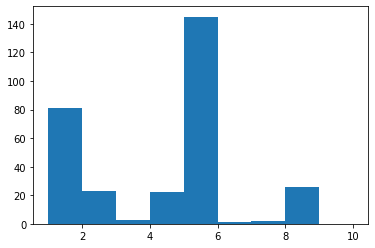

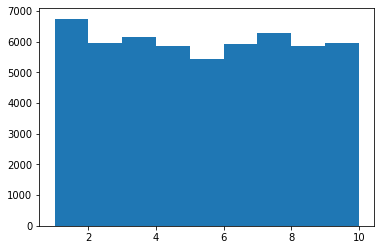

In [95]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
slants = np.array(morpho_train['slant'])
high_slants_idx = np.where(slants > .7)
high_slants_128 = x_train_128[high_slants_idx]
high_slants = x_train[high_slants_idx]

classes = y_train[high_slants_idx]
print(len(high_slants))
plt.hist(classes, bins=list(range(1,11)))
plt.show()
plt.hist(y_train, bins=list(range(1,11)))
plt.show()

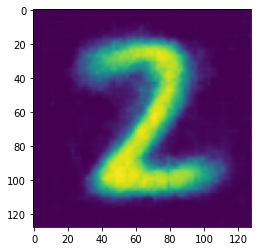

In [96]:
plt.imshow(vae.decoder.predict(np.random.standard_normal((1,2))).squeeze())

/Users/leo/.local/share/virtualenvs/Master_Thesis-iDondhVg/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


VAE encoder Index 1 - MNist digit 0
0.99999464


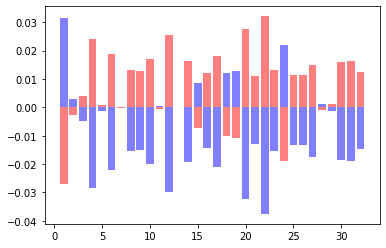

VAE encoder Index 5 - MNist digit 0
0.9956359


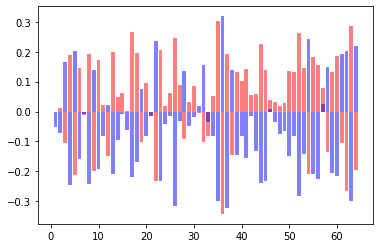

VAE encoder Index 9 - MNist digit 0
0.98386085


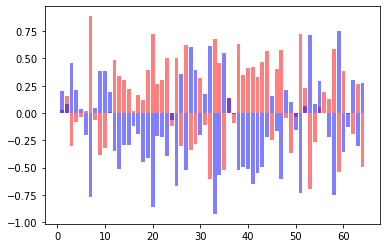

VAE encoder Index 13 - MNist digit 0
0.9221014


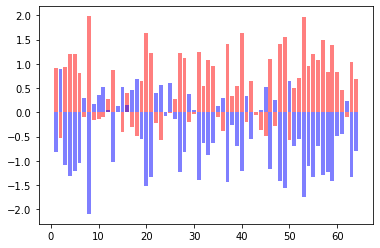

VLAE encoder Index 1 - MNist digit 0
0.95672524


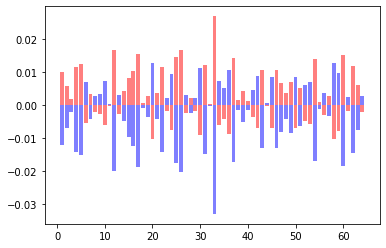

VLAE encoder Index 4 - MNist digit 0
0.98433644


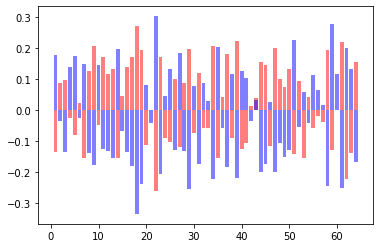

VLAE encoder Index 8 - MNist digit 0
0.9727909


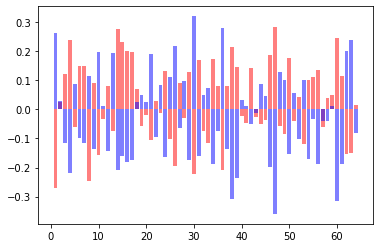

VLAE encoder Index 12 - MNist digit 0
0.950313


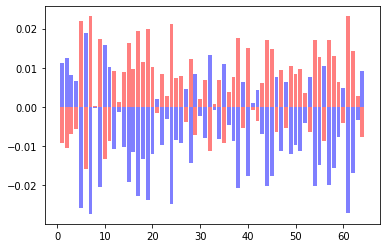

VLAE encoder Index 13 - MNist digit 0
0.9699374


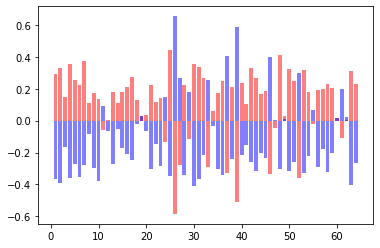

VLAE encoder Index 14 - MNist digit 0
0.9820775


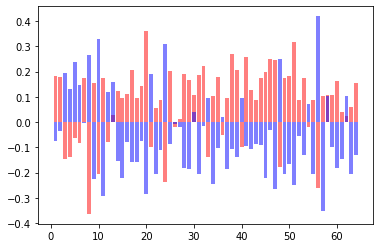

VAE encoder Index 1 - MNist digit 1
0.99999493


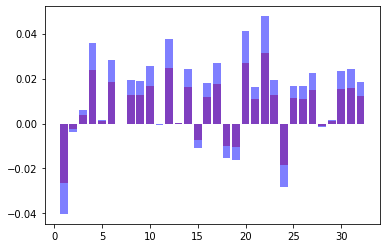

VAE encoder Index 5 - MNist digit 1
0.99592584


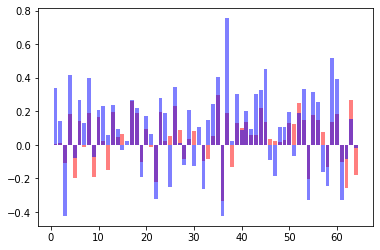

VAE encoder Index 9 - MNist digit 1
0.981714


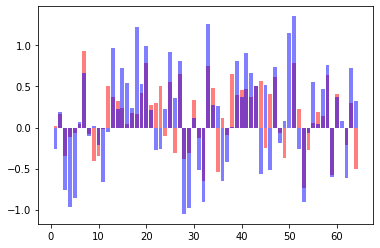

VAE encoder Index 13 - MNist digit 1
0.92099607


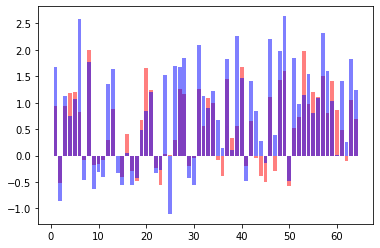

VLAE encoder Index 1 - MNist digit 1
0.9541941


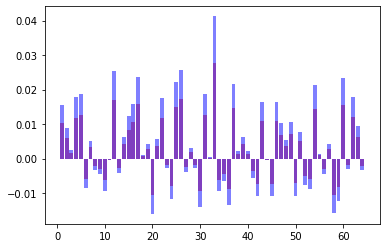

VLAE encoder Index 4 - MNist digit 1
0.98429954


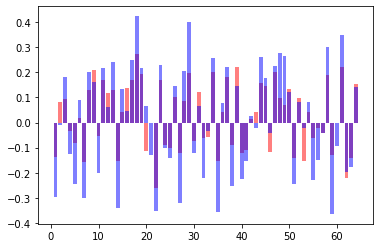

VLAE encoder Index 8 - MNist digit 1
0.9740916


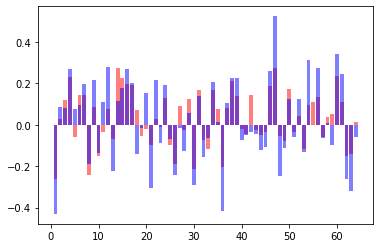

VLAE encoder Index 12 - MNist digit 1
0.9538867


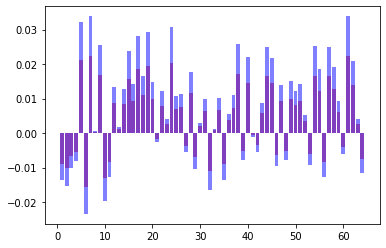

VLAE encoder Index 13 - MNist digit 1
0.9705603


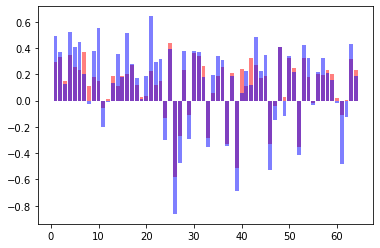

VLAE encoder Index 14 - MNist digit 1
0.9806784


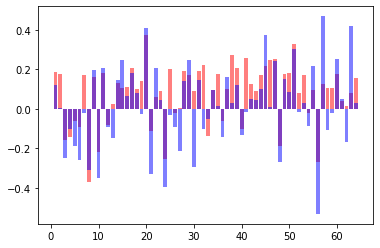

VAE encoder Index 1 - MNist digit 2
0.99999446


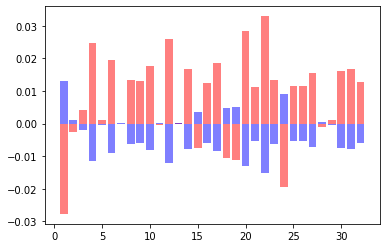

VAE encoder Index 5 - MNist digit 2
0.99571365


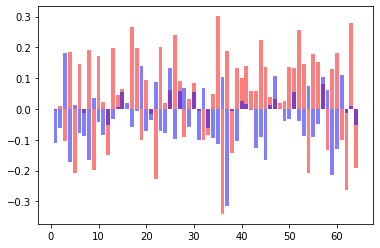

VAE encoder Index 9 - MNist digit 2
0.9803769


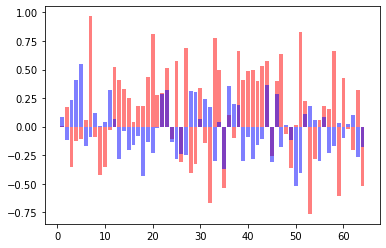

VAE encoder Index 13 - MNist digit 2
0.92713815


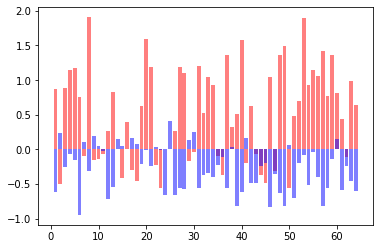

VLAE encoder Index 1 - MNist digit 2
0.9517232


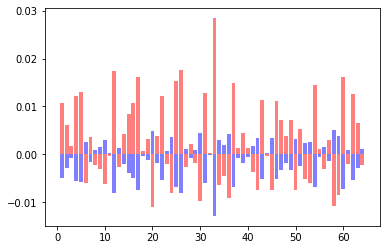

VLAE encoder Index 4 - MNist digit 2
0.9842541


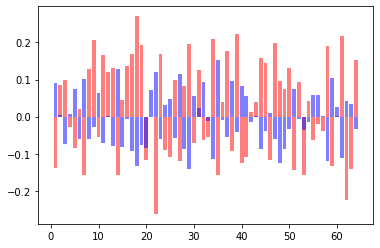

VLAE encoder Index 8 - MNist digit 2
0.9726041


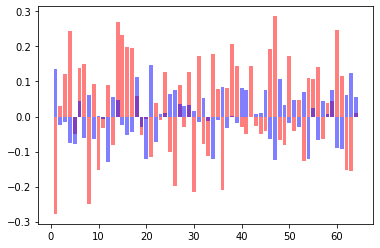

VLAE encoder Index 12 - MNist digit 2
0.9581104


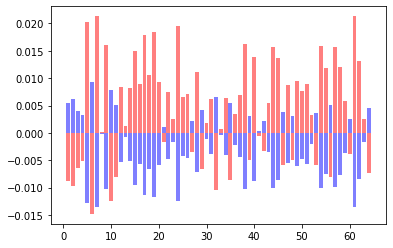

VLAE encoder Index 13 - MNist digit 2
0.9700835


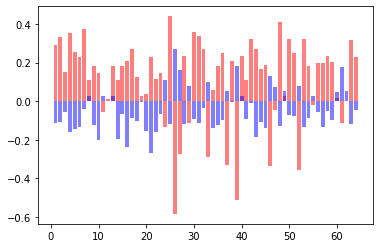

VLAE encoder Index 14 - MNist digit 2
0.9806085


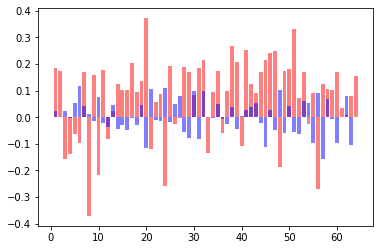

VAE encoder Index 1 - MNist digit 3
0.9999946


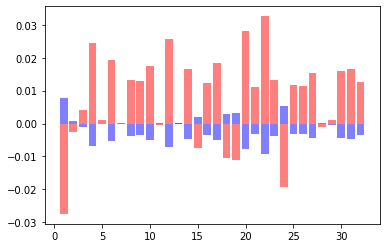

VAE encoder Index 5 - MNist digit 3
0.9958915


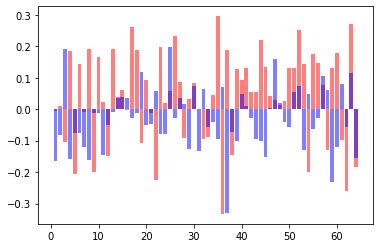

VAE encoder Index 9 - MNist digit 3
0.9820069


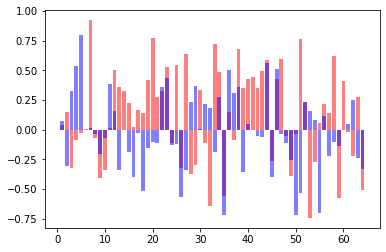

VAE encoder Index 13 - MNist digit 3
0.92097193


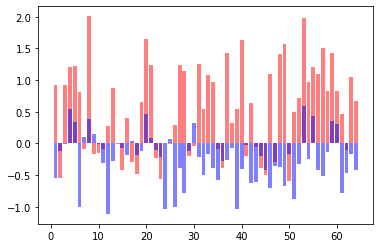

VLAE encoder Index 1 - MNist digit 3
0.95863473


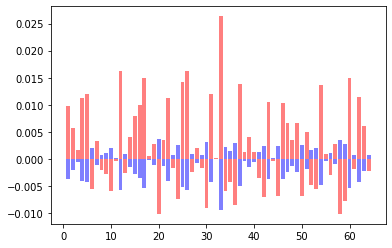

VLAE encoder Index 4 - MNist digit 3
0.9821838


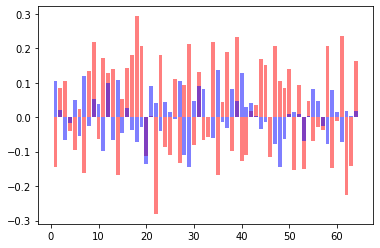

VLAE encoder Index 8 - MNist digit 3
0.9722473


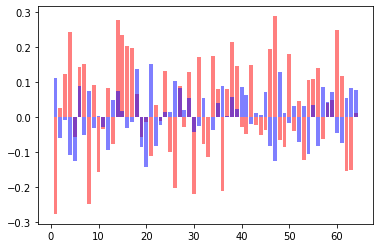

VLAE encoder Index 12 - MNist digit 3
0.9532348


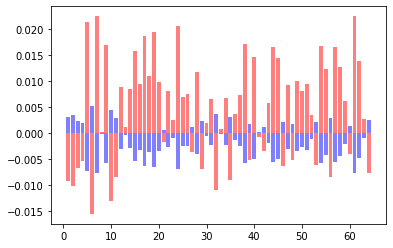

VLAE encoder Index 13 - MNist digit 3
0.9682231


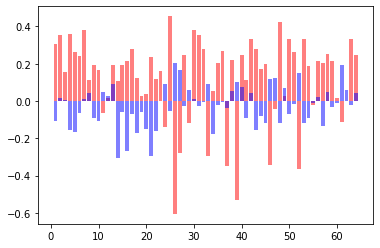

VLAE encoder Index 14 - MNist digit 3
0.981058


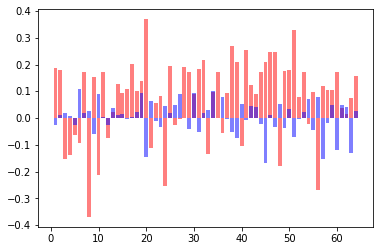

VAE encoder Index 1 - MNist digit 4
0.9999943


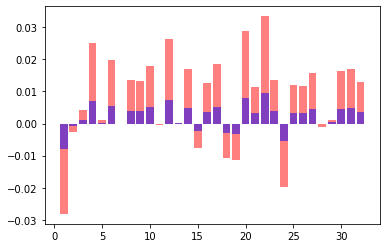

VAE encoder Index 5 - MNist digit 4
0.99579054


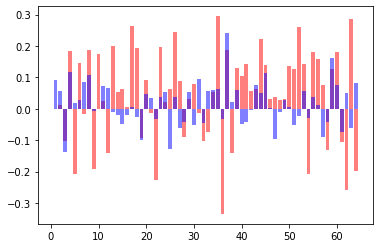

VAE encoder Index 9 - MNist digit 4
0.9826791


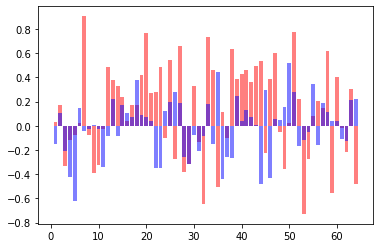

VAE encoder Index 13 - MNist digit 4
0.92101353


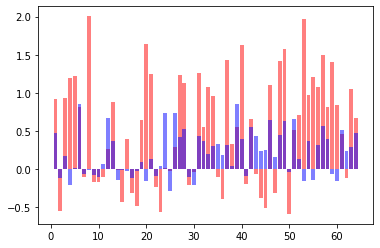

VLAE encoder Index 1 - MNist digit 4
0.95347196


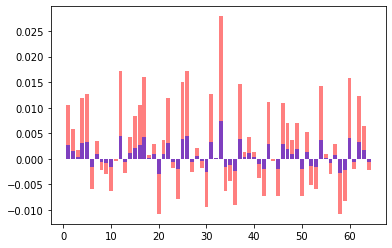

VLAE encoder Index 4 - MNist digit 4
0.9812633


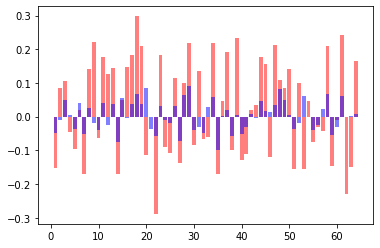

VLAE encoder Index 8 - MNist digit 4
0.96960896


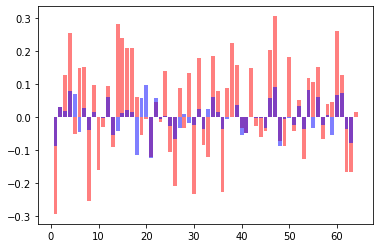

VLAE encoder Index 12 - MNist digit 4
0.9496435


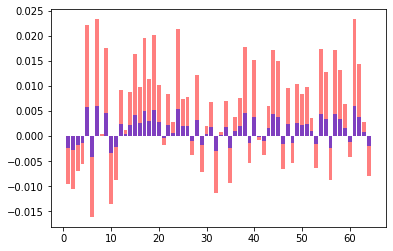

VLAE encoder Index 13 - MNist digit 4
0.97146297


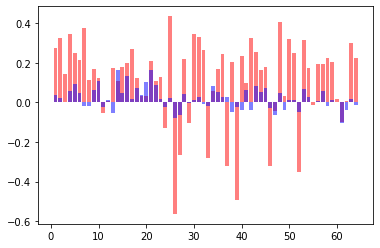

VLAE encoder Index 14 - MNist digit 4
0.9816002


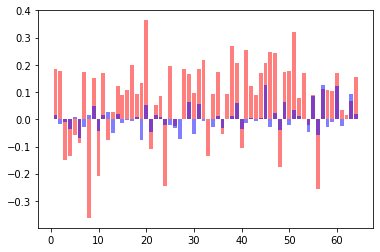

VAE encoder Index 1 - MNist digit 5
0.99999493


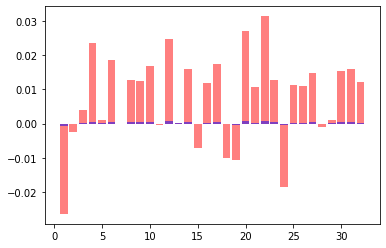

VAE encoder Index 5 - MNist digit 5
0.99552625


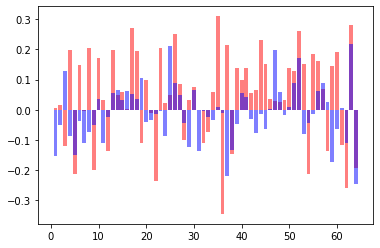

VAE encoder Index 9 - MNist digit 5
0.9822961


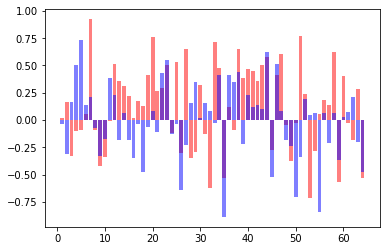

VAE encoder Index 13 - MNist digit 5
0.92198694


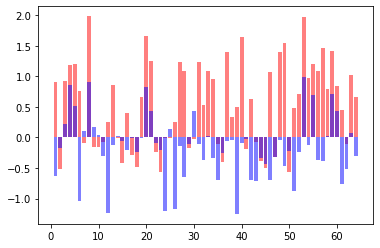

VLAE encoder Index 1 - MNist digit 5
0.9478825


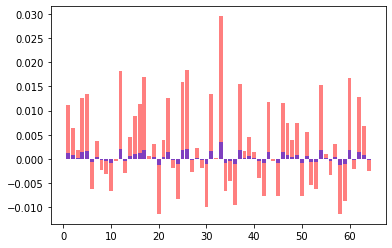

VLAE encoder Index 4 - MNist digit 5
0.98410517


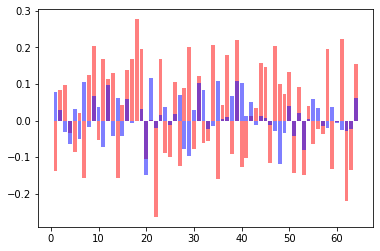

VLAE encoder Index 8 - MNist digit 5
0.97380394


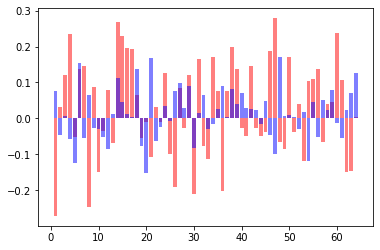

VLAE encoder Index 12 - MNist digit 5


KeyboardInterrupt: 

In [102]:
import sklearn
from utils.statistic import correlation_coefficient

vae_encoder_idx = [1, 5, 9, 13]
vlae_encoder_idx = [1, 4, 8, 12, 13, 14]

for number in range(0, 10):
    num_idxs = sklearn.utils.shuffle(np.where(y_train == number))[:1000]
    nums, nums_128 = x_train[num_idxs], x_train_128[num_idxs]
    num_data, num_data_128 = np.expand_dims(nums, -1), np.expand_dims(nums_128, -1)

    for idx in vae_encoder_idx:
        print("VAE encoder Index {} - MNist digit {}".format(idx, number))
        gt_vae = feature_maps_of_layers(vae.encoder, vae_encoder_idx, np.expand_dims(sklearn.utils.shuffle(x_train_128)[:1000], -1))
        
        slant_vae = feature_maps_of_layers(vae.encoder, vae_encoder_idx, np.expand_dims(sklearn.utils.shuffle(high_slants_128)[:1000], -1))
        
        nums_vae = feature_maps_of_layers(vae.encoder, vae_encoder_idx, num_data_128)
        
        gt_vae_sum_over_fm = np.mean(gt_vae[idx], axis=(1,2))
        slant_vae_sum_over_fm = np.mean(slant_vae[idx], axis=(1,2))
        nums_vae_sum_over_fm = np.mean(nums_vae[idx], axis=(1,2))   
        
        gt_vae_mean_over_samples = np.mean(gt_vae_sum_over_fm, axis=0)
        slant_vae_mean_over_samples = np.mean(slant_vae_sum_over_fm, axis=0)
        nums_vae_mean_over_samples = np.mean(nums_vae_sum_over_fm, axis=0)
        
        print(correlation_coefficient(slant_vae_mean_over_samples,gt_vae_mean_over_samples))
        
        #plt.bar(x=list(range(1,len(gt_mean_over_samples)+1)),height=gt_mean_over_samples, alpha=0.5, color='red')
        plt.bar(x=list(range(1,len(slant_vae_mean_over_samples)+1)),height=slant_vae_mean_over_samples-gt_vae_mean_over_samples, alpha=0.5, color='red')
        plt.bar(x=list(range(1,len(nums_vae_mean_over_samples)+1)),height=nums_vae_mean_over_samples-gt_vae_mean_over_samples, alpha=0.5, color='blue')
        plt.show()
    for idx in vlae_encoder_idx:
        print("VLAE encoder Index {} - MNist digit {}".format(idx, number))
        gt_vlae = feature_maps_of_layers(vlae.encoder, vlae_encoder_idx, np.expand_dims(sklearn.utils.shuffle(x_train)[:1000], -1))
        slant_vlae = feature_maps_of_layers(vlae.encoder, vlae_encoder_idx, np.expand_dims(sklearn.utils.shuffle(high_slants)[:1000], -1))
        nums_vlae = feature_maps_of_layers(vlae.encoder, vlae_encoder_idx, num_data)
        
        gt_vlae_sum_over_fm = np.mean(gt_vlae[idx], axis=(1,2))
        slant_vlae_sum_over_fm = np.mean(slant_vlae[idx], axis=(1,2))
        nums_vlae_sum_over_fm = np.mean(nums_vlae[idx], axis=(1,2))
        
        gt_vlae_mean_over_samples = np.mean(gt_vlae_sum_over_fm, axis=0)
        slant_vlae_mean_over_samples = np.mean(slant_vlae_sum_over_fm, axis=0)
        nums_vlae_mean_over_samples = np.mean(nums_vlae_sum_over_fm, axis=0)
        
        print(correlation_coefficient(slant_vlae_mean_over_samples,gt_vlae_mean_over_samples))
        
        plt.bar(x=list(range(1,len(slant_vlae_mean_over_samples)+1)),height=slant_vlae_mean_over_samples-gt_vlae_mean_over_samples, alpha=0.5, color='red')
        plt.bar(x=list(range(1,len(nums_vlae_mean_over_samples)+1)),height=nums_vlae_mean_over_samples-gt_vlae_mean_over_samples, alpha=0.5, color='blue')
        plt.show()

In [97]:
import sklearn

hs_vlae_layers = vlae.encoder.predict(np.expand_dims(high_slants, -1))
hs_vae_layer = vae.encoder.predict(np.expand_dims(high_slants_128, -1))
hs_vlae_means = [np.mean(hs_layer, axis=0) for hs_layer in hs_vlae_layers]
hs_vae_mean = np.mean(hs_vae_layer, axis=0)
num_vlae_means = {}
num_vae_means = {}
for num in range(10):
    num_idxs = sklearn.utils.shuffle(np.where(y_train == num))[:1000]
    n_vlae_layers = vlae.encoder.predict(np.expand_dims(x_train[num_idxs], -1))
    n_vae_layer = vae.encoder.predict(np.expand_dims(x_train_128[num_idxs], -1))
    n_vlae_means = [np.mean(n_layer, axis=0) for n_layer in n_vlae_layers]
    n_vae_mean = np.mean(n_vae_layer, axis=0)
    num_vlae_means[num] = n_vlae_means
    num_vae_means[num] = n_vae_mean

/Users/leo/.local/share/virtualenvs/Master_Thesis-iDondhVg/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/Users/leo/.local/share/virtualenvs/Master_Thesis-iDondhVg/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


In [98]:
gt_vlae_generated = [np.random.standard_normal((1000,2)) for _ in range(3)]
gt_vae_generated = np.random.standard_normal((1000,2))
high_slant_vlae_generated = [np.random.normal(loc = hs_mean, size=(1000,2)) for hs_mean in hs_vlae_means]
high_slant_vae_generated = np.random.normal(loc = hs_vae_mean, size=(1000,2))
num_vlae_generated = {}
num_vae_generated = {}
for k in num_vlae_means.keys():
    num_vlae_generated[k] = [np.random.normal(loc = w, size=(1000,2)) for w in num_vlae_means[k]]
    num_vae_generated[k] = np.random.normal(loc = num_vae_means[k], size=(1000,2))

VAE decoder Index 1 - MNist digit 0
-0.87701225


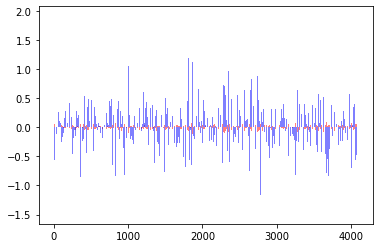

VAE decoder Index 3 - MNist digit 0
-0.9759213


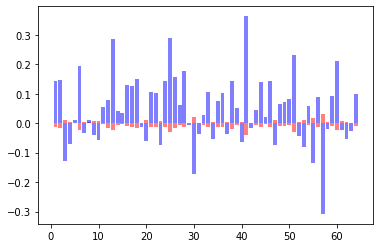

VAE decoder Index 7 - MNist digit 0
0.23010193


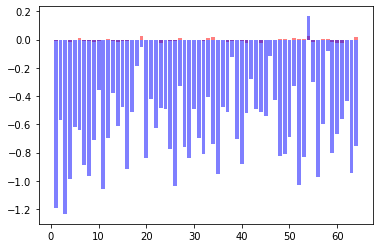

VAE decoder Index 11 - MNist digit 0
-0.7678608


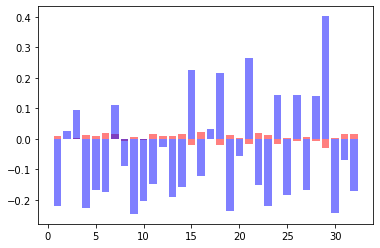

VAE decoder Index 15 - MNist digit 0
nan


/Users/leo/IdeaProjects/Masterarbeit/Master Thesis/utils/statistic.py:55: RuntimeWarning: invalid value encountered in float_scalars
  return np.dot(a_centered, b_centered) / np.sqrt(np.dot(a_centered, a_centered) * np.dot(b_centered, b_centered))


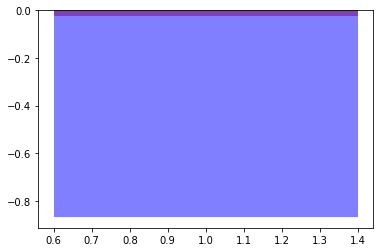

VLAE decoder Index 1 - MNist digit 0
0.24462552


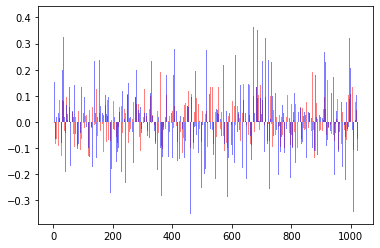

VLAE decoder Index 5 - MNist digit 0
0.28032655


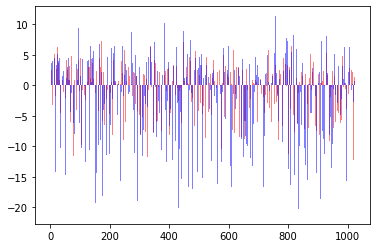

VLAE decoder Index 11 - MNist digit 0
0.48421955


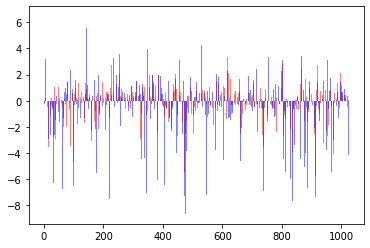

VLAE decoder Index 15 - MNist digit 0
0.27564996


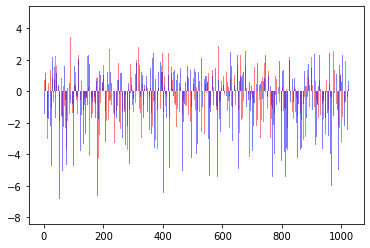

VLAE decoder Index 21 - MNist digit 0
0.2509021


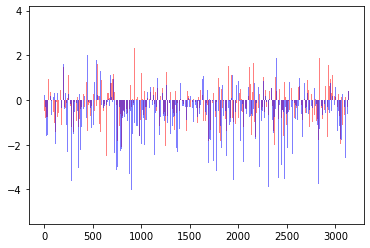

VLAE decoder Index 26 - MNist digit 0
-0.15919587


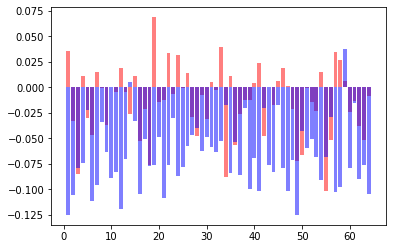

VLAE decoder Index 30 - MNist digit 0
nan


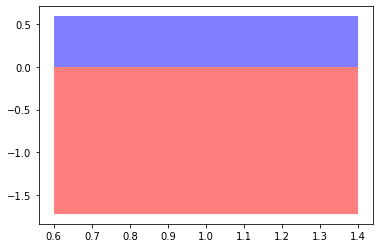

VAE decoder Index 1 - MNist digit 1
0.9975739


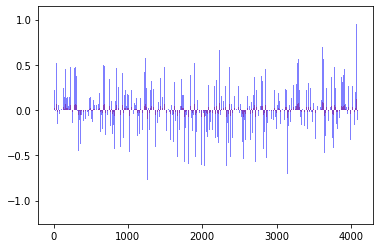

VAE decoder Index 3 - MNist digit 1
0.99959934


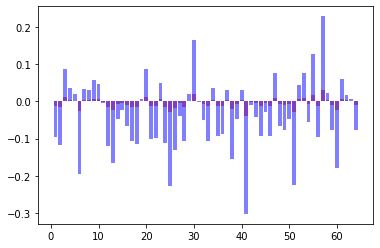

VAE decoder Index 7 - MNist digit 1
0.85249436


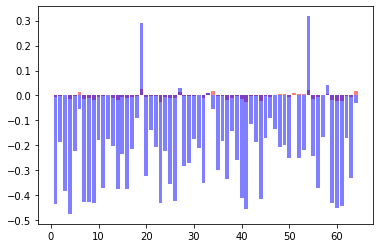

VAE decoder Index 11 - MNist digit 1
0.9431641


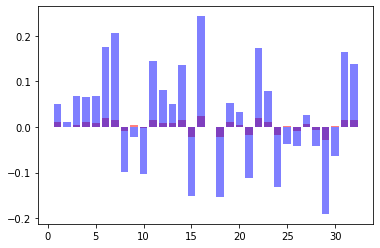

VAE decoder Index 15 - MNist digit 1
nan


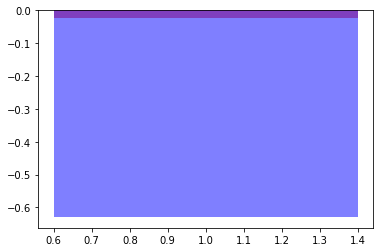

VLAE decoder Index 1 - MNist digit 1
0.064270005


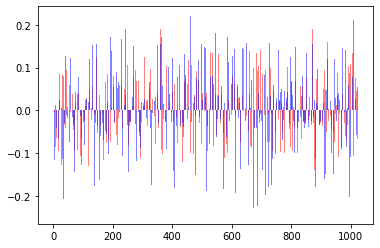

VLAE decoder Index 5 - MNist digit 1
0.19242409


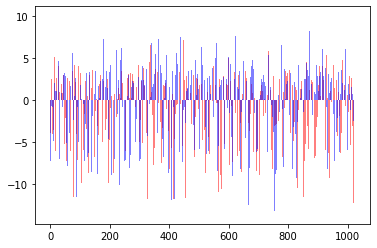

VLAE decoder Index 11 - MNist digit 1
0.36965486


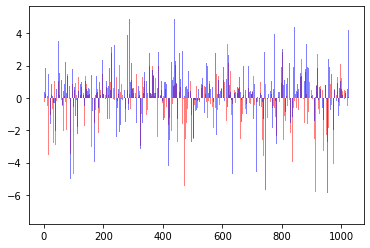

VLAE decoder Index 15 - MNist digit 1
0.39262205


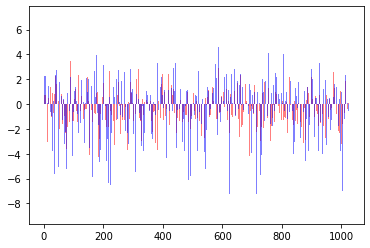

VLAE decoder Index 21 - MNist digit 1
0.482274


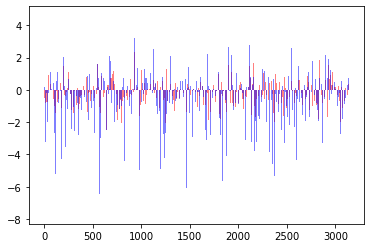

VLAE decoder Index 26 - MNist digit 1
0.80006313


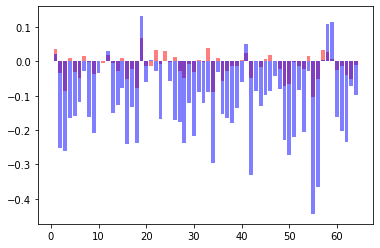

VLAE decoder Index 30 - MNist digit 1
nan


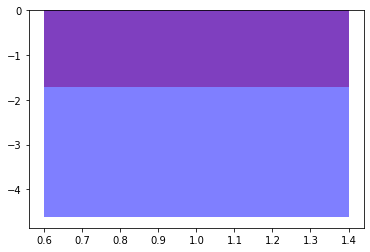

VAE decoder Index 1 - MNist digit 2
0.23073813


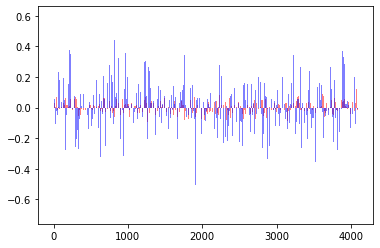

VAE decoder Index 3 - MNist digit 2
0.5201398


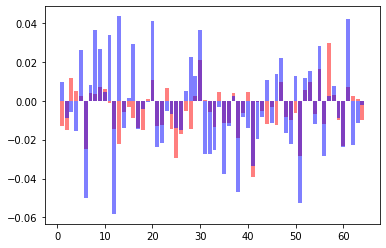

VAE decoder Index 7 - MNist digit 2
0.6925584


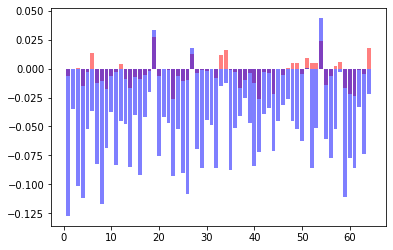

VAE decoder Index 11 - MNist digit 2
0.623189


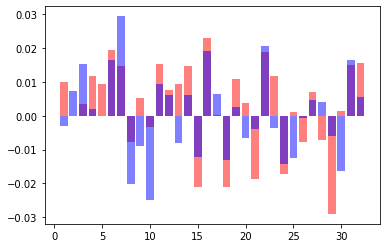

VAE decoder Index 15 - MNist digit 2
nan


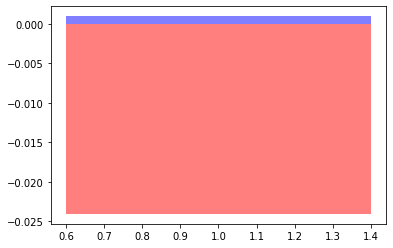

VLAE decoder Index 1 - MNist digit 2
0.9759714


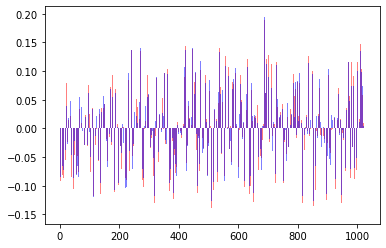

VLAE decoder Index 5 - MNist digit 2
0.98259896


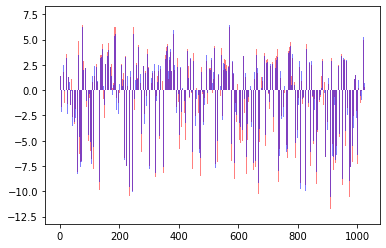

VLAE decoder Index 11 - MNist digit 2
0.9287917


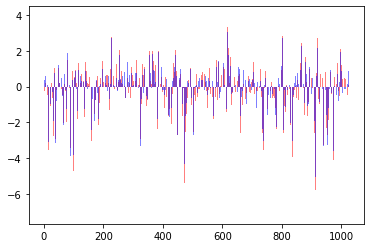

VLAE decoder Index 15 - MNist digit 2
0.4521786


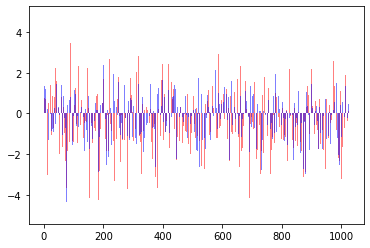

VLAE decoder Index 21 - MNist digit 2
0.48721892


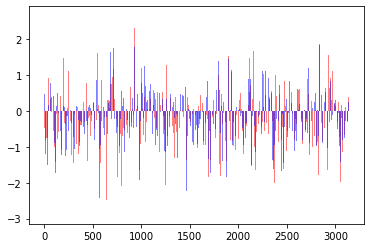

VLAE decoder Index 26 - MNist digit 2
0.17041923


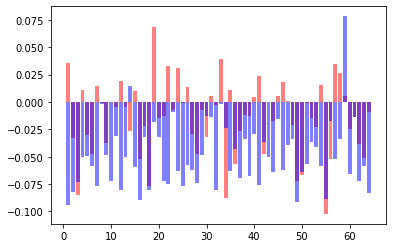

VLAE decoder Index 30 - MNist digit 2
nan


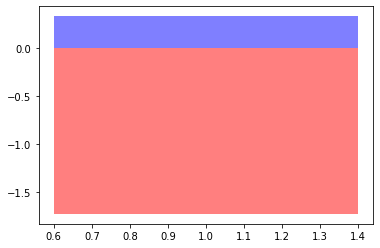

VAE decoder Index 1 - MNist digit 3
-0.80815196


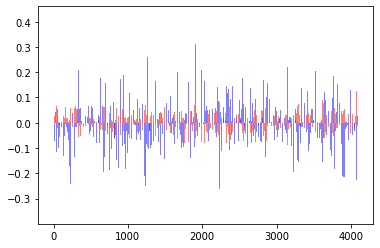

VAE decoder Index 3 - MNist digit 3
-0.9594963


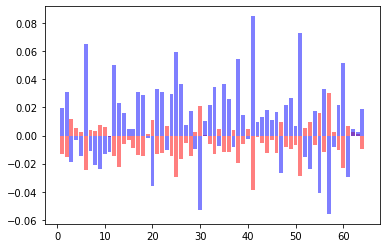

VAE decoder Index 7 - MNist digit 3
-0.029260311


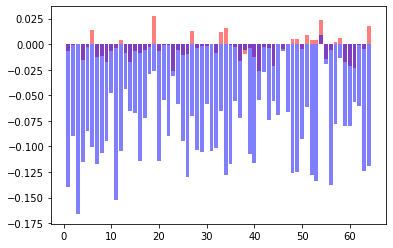

VAE decoder Index 11 - MNist digit 3
-0.913511


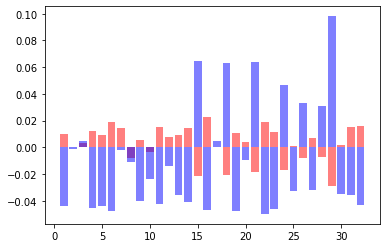

VAE decoder Index 15 - MNist digit 3
nan


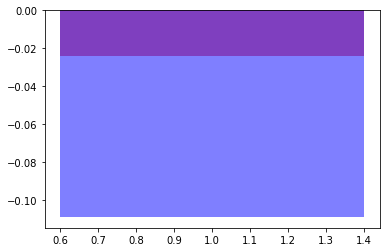

VLAE decoder Index 1 - MNist digit 3
-0.85768294


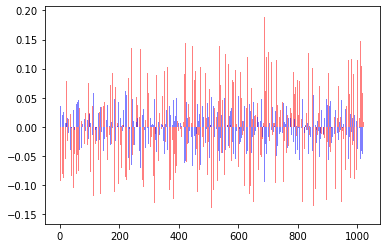

VLAE decoder Index 5 - MNist digit 3
-0.7367653


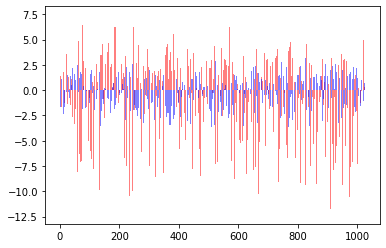

VLAE decoder Index 11 - MNist digit 3
-0.5715695


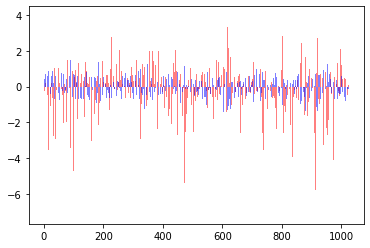

VLAE decoder Index 15 - MNist digit 3
-0.17896783


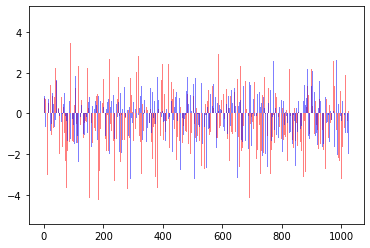

VLAE decoder Index 21 - MNist digit 3
-0.17796685


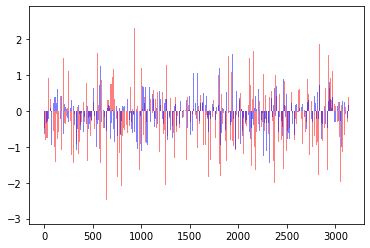

VLAE decoder Index 26 - MNist digit 3
0.11659535


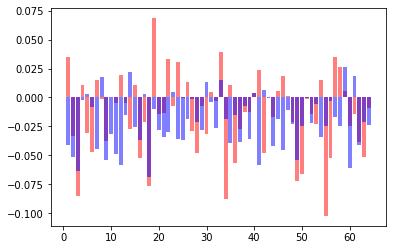

VLAE decoder Index 30 - MNist digit 3
nan


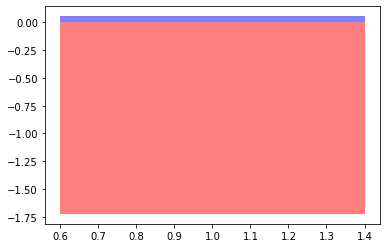

VAE decoder Index 1 - MNist digit 4
0.2515175


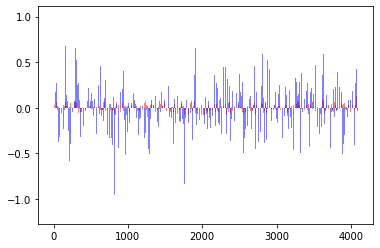

VAE decoder Index 3 - MNist digit 4
0.52433676


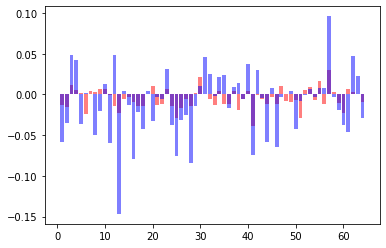

VAE decoder Index 7 - MNist digit 4
0.57991385


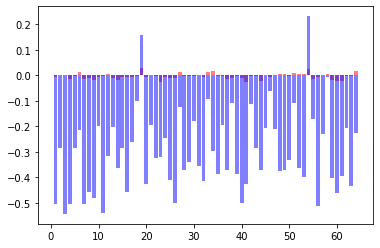

VAE decoder Index 11 - MNist digit 4
-0.33846745


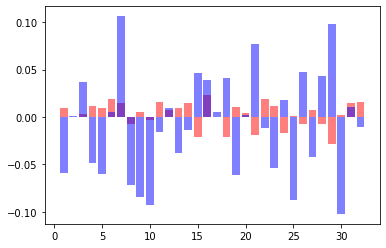

VAE decoder Index 15 - MNist digit 4
nan


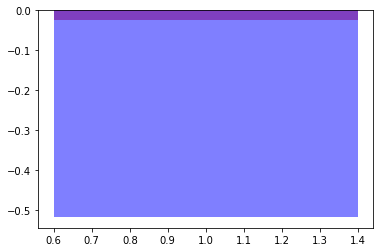

VLAE decoder Index 1 - MNist digit 4
-0.39003083


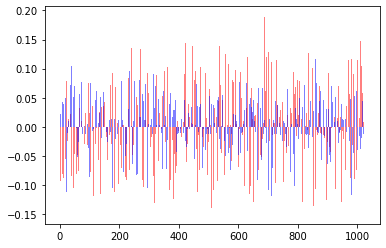

VLAE decoder Index 5 - MNist digit 4
-0.33038968


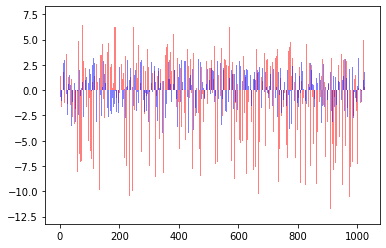

VLAE decoder Index 11 - MNist digit 4
-0.13611245


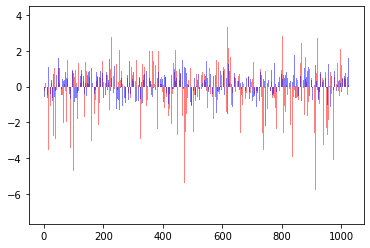

VLAE decoder Index 15 - MNist digit 4
0.1890774


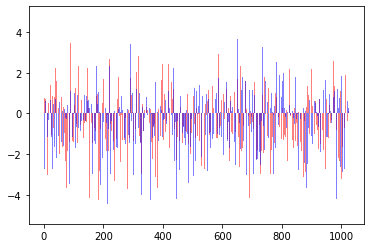

VLAE decoder Index 21 - MNist digit 4
0.20315045


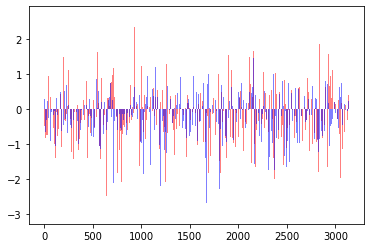

VLAE decoder Index 26 - MNist digit 4
0.2768908


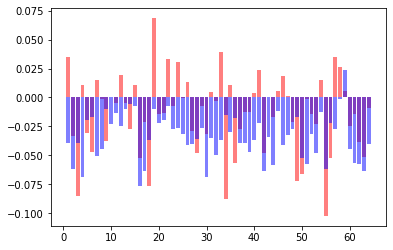

VLAE decoder Index 30 - MNist digit 4
nan


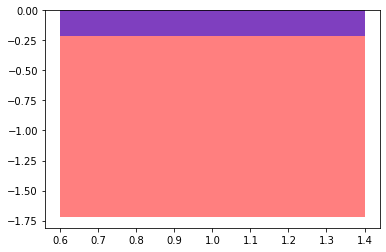

VAE decoder Index 1 - MNist digit 5
-0.7232826


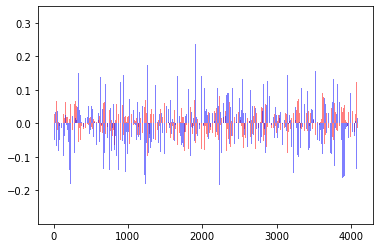

VAE decoder Index 3 - MNist digit 5
-0.9336116


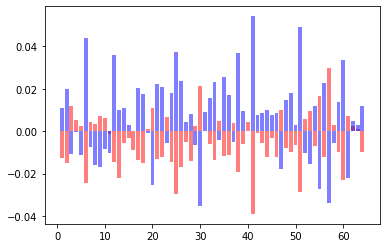

VAE decoder Index 7 - MNist digit 5
0.07868222


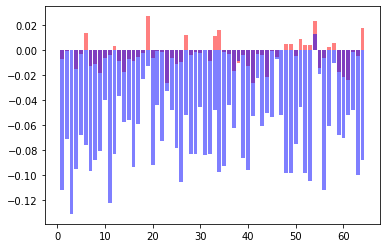

VAE decoder Index 11 - MNist digit 5
-0.8947208


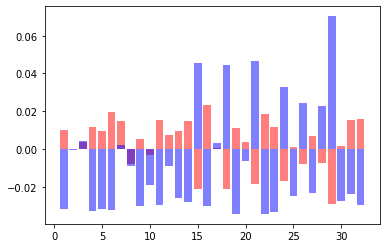

VAE decoder Index 15 - MNist digit 5
nan


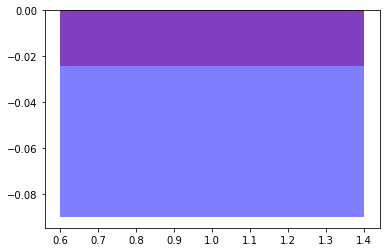

VLAE decoder Index 1 - MNist digit 5
-0.31269422


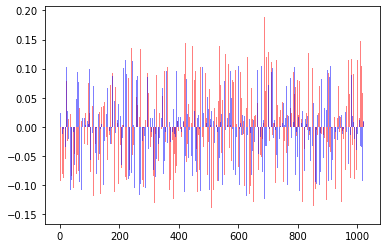

VLAE decoder Index 5 - MNist digit 5
-0.2978798


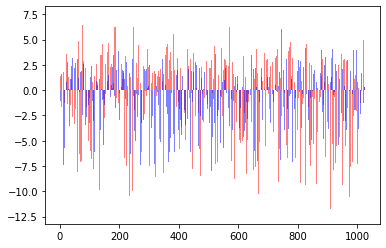

VLAE decoder Index 11 - MNist digit 5
-0.11904379


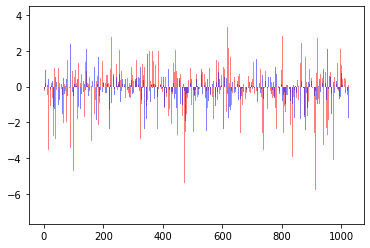

VLAE decoder Index 15 - MNist digit 5
0.11380244


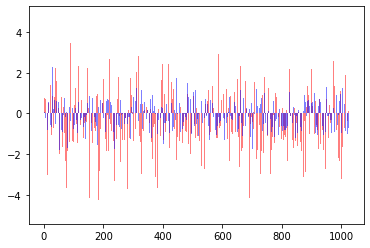

VLAE decoder Index 21 - MNist digit 5
0.024335044


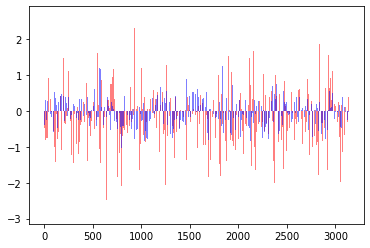

VLAE decoder Index 26 - MNist digit 5
0.4286043


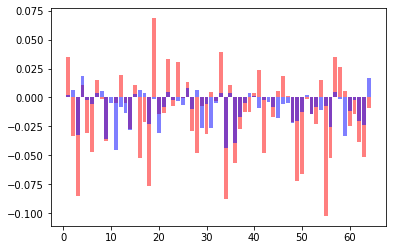

VLAE decoder Index 30 - MNist digit 5
nan


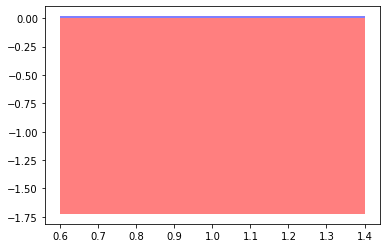

VAE decoder Index 1 - MNist digit 6
-0.9424323


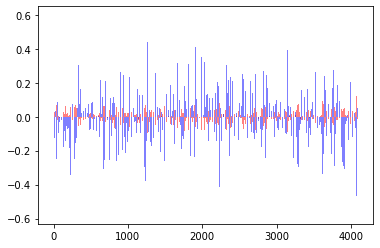

VAE decoder Index 3 - MNist digit 6
-0.9898604


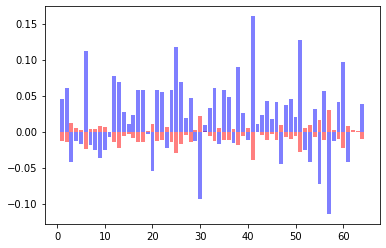

VAE decoder Index 7 - MNist digit 6
-0.01516554


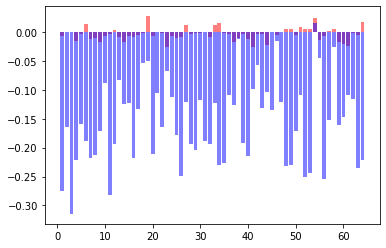

VAE decoder Index 11 - MNist digit 6
-0.90016854


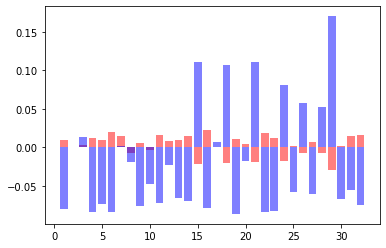

VAE decoder Index 15 - MNist digit 6
nan


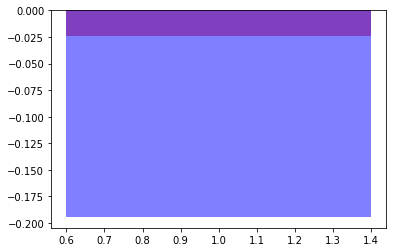

VLAE decoder Index 1 - MNist digit 6
0.8363446


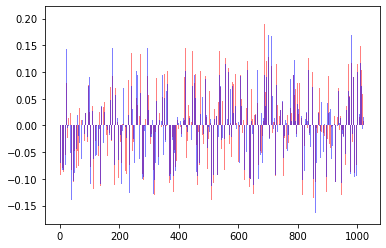

VLAE decoder Index 5 - MNist digit 6
0.864657


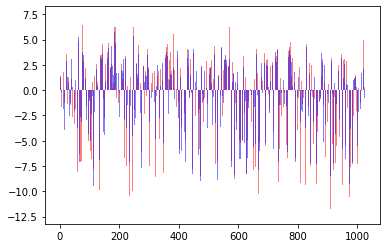

VLAE decoder Index 11 - MNist digit 6
0.78597516


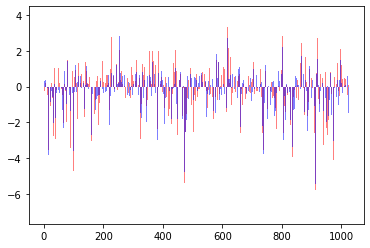

VLAE decoder Index 15 - MNist digit 6
0.0032525866


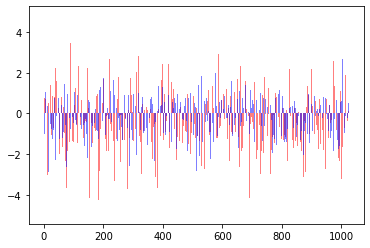

VLAE decoder Index 21 - MNist digit 6
0.19938475


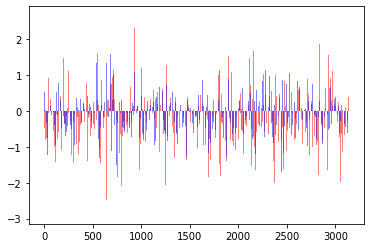

VLAE decoder Index 26 - MNist digit 6
-0.16019665


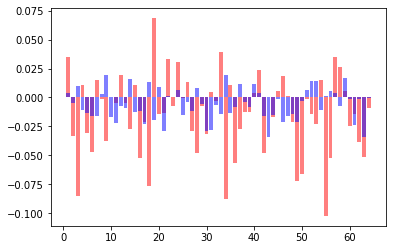

VLAE decoder Index 30 - MNist digit 6
nan


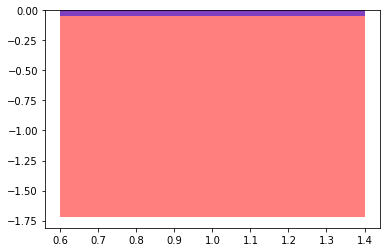

VAE decoder Index 1 - MNist digit 7
0.6899611


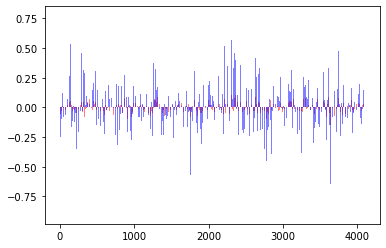

VAE decoder Index 3 - MNist digit 7
0.91860104


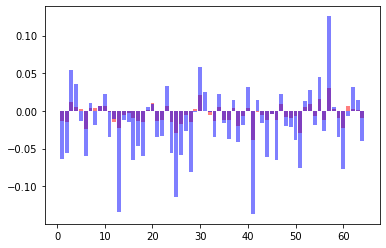

VAE decoder Index 7 - MNist digit 7
0.776853


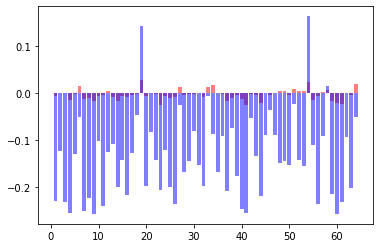

VAE decoder Index 11 - MNist digit 7
0.80038726


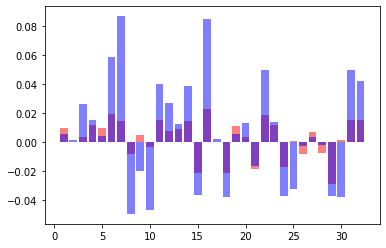

VAE decoder Index 15 - MNist digit 7
nan


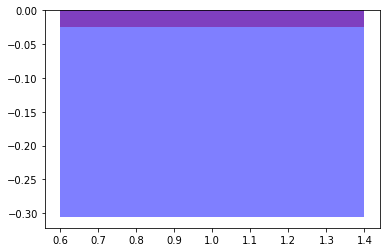

VLAE decoder Index 1 - MNist digit 7
-0.7276631


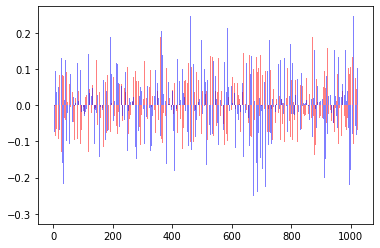

VLAE decoder Index 5 - MNist digit 7
-0.51669693


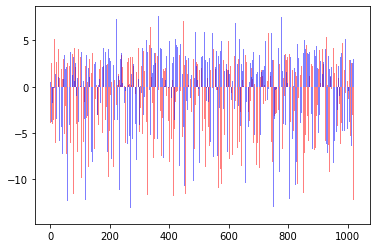

VLAE decoder Index 11 - MNist digit 7
-0.2070293


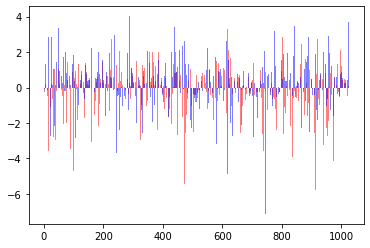

VLAE decoder Index 15 - MNist digit 7
0.35195035


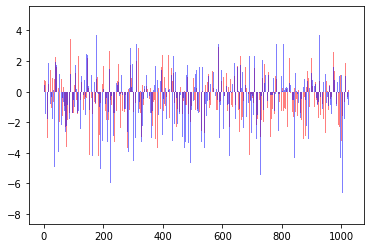

VLAE decoder Index 21 - MNist digit 7
0.30490747


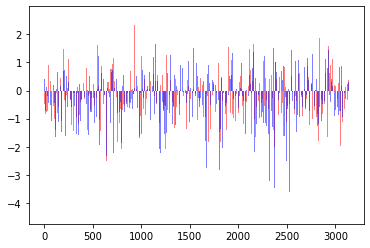

VLAE decoder Index 26 - MNist digit 7
0.7355972


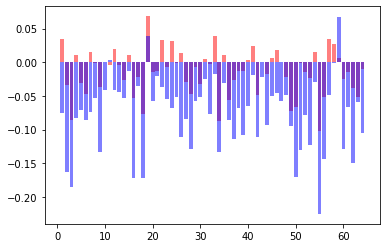

VLAE decoder Index 30 - MNist digit 7
nan


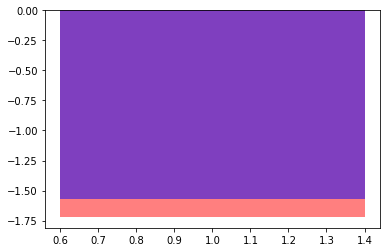

VAE decoder Index 1 - MNist digit 8
-0.27806926


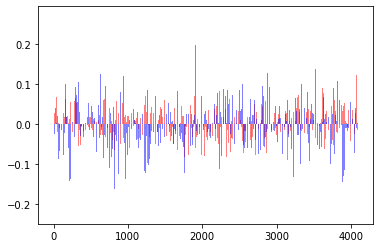

VAE decoder Index 3 - MNist digit 8
-0.5938671


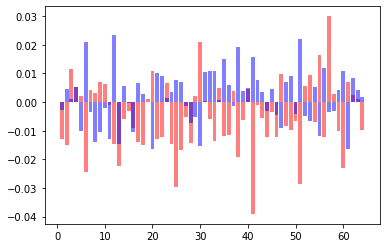

VAE decoder Index 7 - MNist digit 8
0.32625026


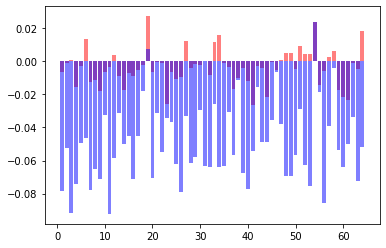

VAE decoder Index 11 - MNist digit 8
-0.82370293


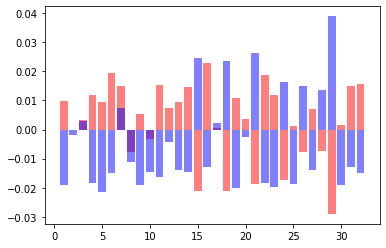

VAE decoder Index 15 - MNist digit 8
nan


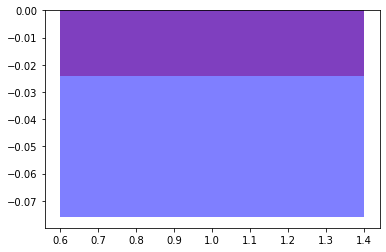

VLAE decoder Index 1 - MNist digit 8
-0.75296813


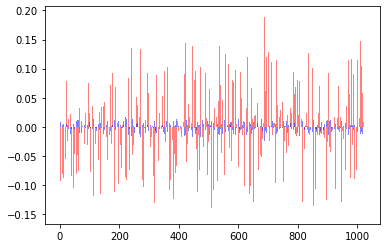

VLAE decoder Index 5 - MNist digit 8
-0.7563373


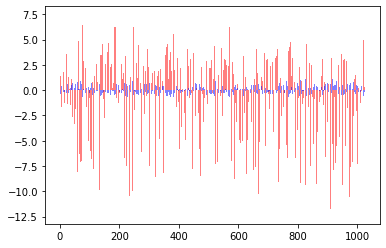

VLAE decoder Index 11 - MNist digit 8
-0.63319916


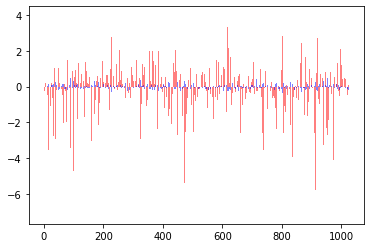

VLAE decoder Index 15 - MNist digit 8
0.017385285


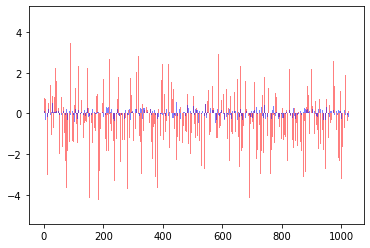

VLAE decoder Index 21 - MNist digit 8
-0.24945515


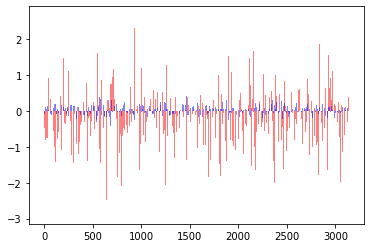

VLAE decoder Index 26 - MNist digit 8
-0.18399888


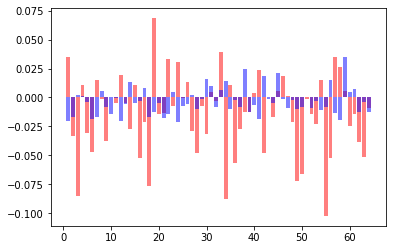

VLAE decoder Index 30 - MNist digit 8
nan


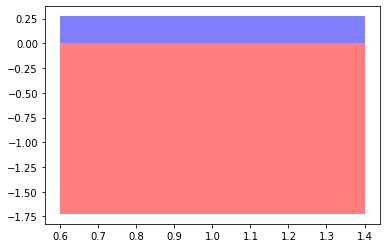

VAE decoder Index 1 - MNist digit 9
0.31735724


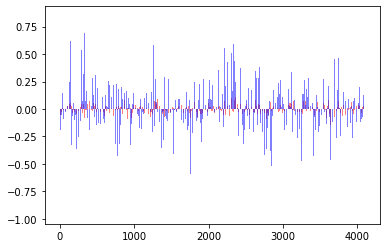

VAE decoder Index 3 - MNist digit 9
0.6247435


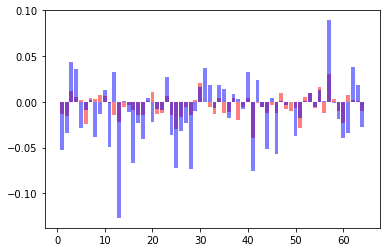

VAE decoder Index 7 - MNist digit 9
0.61018705


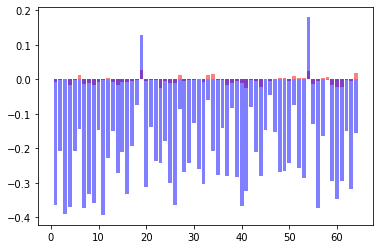

VAE decoder Index 11 - MNist digit 9
-0.1970944


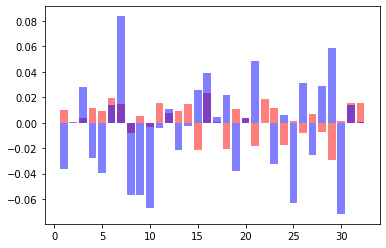

VAE decoder Index 15 - MNist digit 9
nan


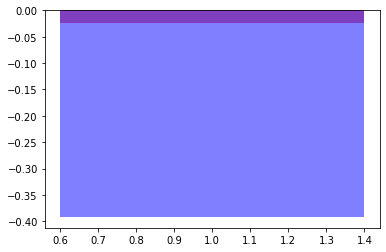

VLAE decoder Index 1 - MNist digit 9
-0.90154403


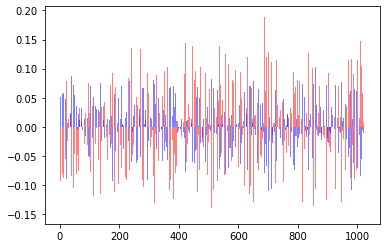

VLAE decoder Index 5 - MNist digit 9
-0.7466925


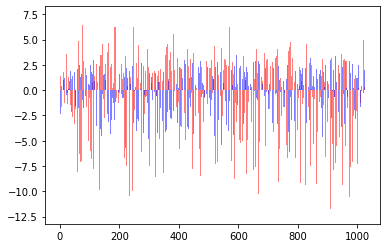

VLAE decoder Index 11 - MNist digit 9
-0.54194707


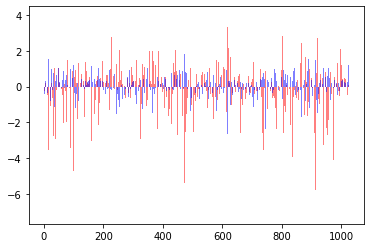

VLAE decoder Index 15 - MNist digit 9
0.07444625


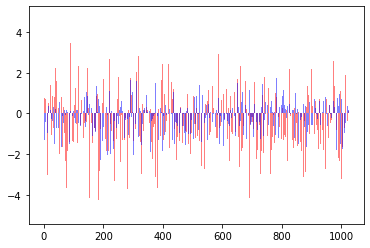

VLAE decoder Index 21 - MNist digit 9
-0.04927199


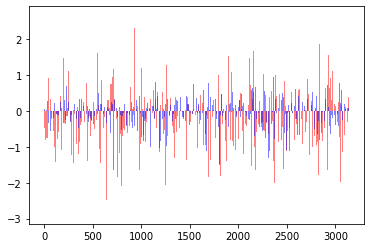

VLAE decoder Index 26 - MNist digit 9
0.44462594


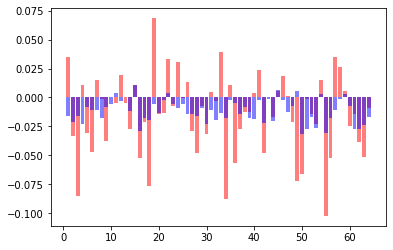

VLAE decoder Index 30 - MNist digit 9
nan


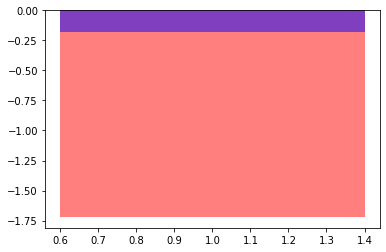

In [100]:
import sklearn
from utils.statistic import correlation_coefficient

vae_decoder_idx = [1, 3, 7, 11, 15]
vlae_decoder_idx = [1, 5, 11, 15, 21, 26, 30]

for number in range(0, 10):

    for idx in vae_decoder_idx:
        print("VAE decoder Index {} - MNist digit {}".format(idx, number))
        gt_vae = feature_maps_of_layers(vae.decoder, vae_decoder_idx, gt_vae_generated)
        
        slant_vae = feature_maps_of_layers(vae.decoder, vae_decoder_idx, high_slant_vae_generated)
        
        nums_vae = feature_maps_of_layers(vae.decoder, vae_decoder_idx, num_vae_generated[number])
        
        gt_vae_sum_over_fm = np.mean(gt_vae[idx], axis=(1,2)) if len(gt_vae[idx].shape) == 4 else gt_vae[idx]
        slant_vae_sum_over_fm = np.mean(slant_vae[idx], axis=(1,2)) if len(slant_vae[idx].shape) == 4 else slant_vae[idx]
        nums_vae_sum_over_fm = np.mean(nums_vae[idx], axis=(1,2)) if len(nums_vae[idx].shape) == 4 else nums_vae[idx]
        
        gt_vae_mean_over_samples = np.mean(gt_vae_sum_over_fm, axis=0)
        slant_vae_mean_over_samples = np.mean(slant_vae_sum_over_fm, axis=0)
        nums_vae_mean_over_samples = np.mean(nums_vae_sum_over_fm, axis=0)
        
        print(correlation_coefficient(slant_vae_mean_over_samples-gt_vae_mean_over_samples, nums_vae_mean_over_samples-gt_vae_mean_over_samples))
        
        #plt.bar(x=list(range(1,len(gt_mean_over_samples)+1)),height=gt_mean_over_samples, alpha=0.5, color='red')
        plt.bar(x=list(range(1,len(slant_vae_mean_over_samples)+1)),height=slant_vae_mean_over_samples-gt_vae_mean_over_samples, alpha=0.5, color='red')
        plt.bar(x=list(range(1,len(nums_vae_mean_over_samples)+1)),height=nums_vae_mean_over_samples-gt_vae_mean_over_samples, alpha=0.5, color='blue')
        plt.show()
    for idx in vlae_decoder_idx:
        print("VLAE decoder Index {} - MNist digit {}".format(idx, number))
        gt_vlae = feature_maps_of_layers(vlae.decoder, vlae_decoder_idx, gt_vlae_generated)
        slant_vlae = feature_maps_of_layers(vlae.decoder, vlae_decoder_idx, high_slant_vlae_generated)
        nums_vlae = feature_maps_of_layers(vlae.decoder, vlae_decoder_idx, num_vlae_generated[number])
        
        gt_vlae_sum_over_fm = np.mean(gt_vlae[idx], axis=(1,2)) if len(gt_vlae[idx].shape) == 4 else gt_vlae[idx]
        slant_vlae_sum_over_fm = np.mean(slant_vlae[idx], axis=(1,2)) if len(slant_vlae[idx].shape) == 4 else slant_vlae[idx]
        nums_vlae_sum_over_fm = np.mean(nums_vlae[idx], axis=(1,2)) if len(nums_vlae[idx].shape) == 4 else nums_vlae[idx]
        
        gt_vlae_mean_over_samples = np.mean(gt_vlae_sum_over_fm, axis=0)
        slant_vlae_mean_over_samples = np.mean(slant_vlae_sum_over_fm, axis=0)
        nums_vlae_mean_over_samples = np.mean(nums_vlae_sum_over_fm, axis=0)
        
        print(correlation_coefficient(slant_vlae_mean_over_samples-gt_vlae_mean_over_samples, nums_vlae_mean_over_samples-gt_vlae_mean_over_samples))
        
        plt.bar(x=list(range(1,len(slant_vlae_mean_over_samples)+1)),height=slant_vlae_mean_over_samples-gt_vlae_mean_over_samples, alpha=0.5, color='red')
        plt.bar(x=list(range(1,len(nums_vlae_mean_over_samples)+1)),height=nums_vlae_mean_over_samples-gt_vlae_mean_over_samples, alpha=0.5, color='blue')
        plt.show()

In [25]:
vae_28 = VAE(input_dim=(28,28,1), encoder_conv_filters=[32, 64, 64, 64],
                    encoder_conv_kernel_size=[3, 3, 3, 3], encoder_conv_strides=[2, 2, 1, 1],
                    decoder_conv_t_filters=[64, 64, 32, 1],
                    decoder_conv_t_kernel_size=[3, 3, 3, 3],
                    decoder_conv_t_strides=[1, 1, 2, 2], log_dir='', z_dims=[2],
                    feature_map_layers=[], use_batch_norm=True,kernel_visualization_layer=-1,
                    decay_rate=0., num_samples=1,
                    feature_map_reduction_factor=1,
                    inner_activation='ReLU', dropout_rate=0.3)
vae_28.load_weights('/Users/leo/Downloads/vae_28.h5')

In [38]:
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (_, _) = mnist.load_data()
y_train = sklearn.preprocessing.OneHotEncoder().fit_transform(y_train.reshape(-1, 1))
x_train = np.expand_dims(x_train, axis=-1)
x_train, y_train = shuffle(x_train, y_train)

x = inpt = Input(shape=(28,28,1))
x = Conv2D(batch_input_shape=(28,28,1), filters=20, kernel_size=5)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(filters=20, kernel_size=3)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(100)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = outpt = Dense(10, activation='softmax')(x)

model = Model(inpt, outpt)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 20)        520       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 24, 24, 20)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 24, 24, 20)        80        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 20)        3620      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 22, 22, 20)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 22, 22, 20)        80        
__________

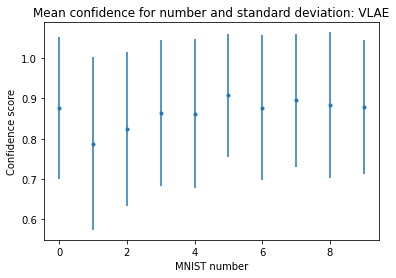

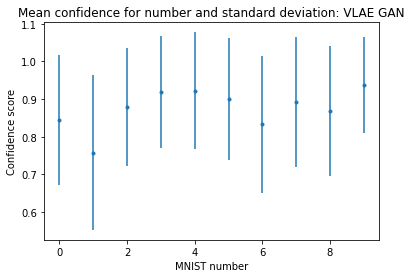

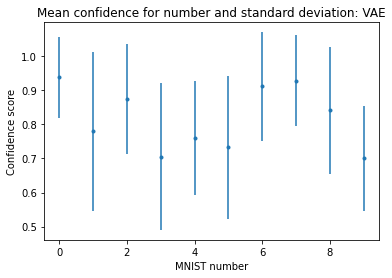

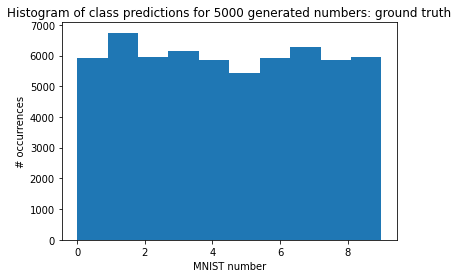

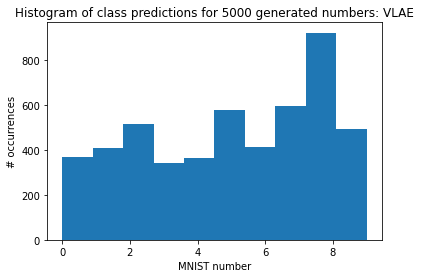

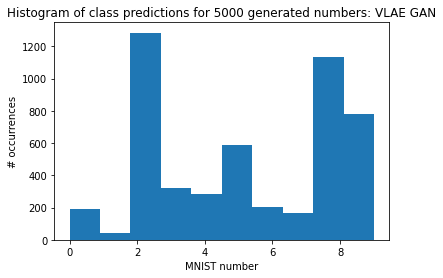

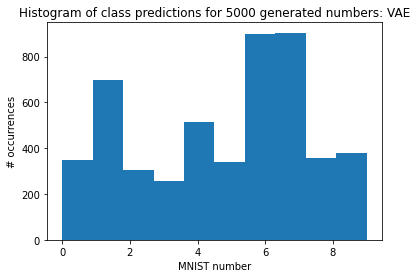

In [122]:
samples = 5000

vlae_generated = vlae.decoder.predict([np.random.normal(size=(samples,2),loc=(0, 0)),np.random.normal(size=(samples,2),loc=(0,0)),np.random.normal(loc=(0,0), size=(samples,2))]).squeeze()*255.0
vlaegan_generated = vlaegan_decoder.predict([np.random.normal(size=(samples,2),loc=(0, 0)),np.random.normal(size=(samples,2),loc=(0,0)),np.random.normal(loc=(0,0), size=(samples,2))]).squeeze()*255.0
vae_generated = vae_28.decoder.predict(np.random.normal(size=(samples,2),loc=(0, 0))).squeeze()*255.0

vlae_raw_preds = model.predict(np.expand_dims(vlae_generated, -1))
vlaegan_raw_preds = model.predict(np.expand_dims(vlaegan_generated, -1))
vae_raw_preds = model.predict(np.expand_dims(vae_generated, -1))

vlaegan_num_means, vlae_num_means, vae_num_means = [], [], []
vlaegan_num_sds, vlae_num_sds, vae_num_sds = [], [], []

for num in range(10):
    vlae_num_is_max_idxs = np.where(np.argmax(vlae_raw_preds, axis=1) == num)
    vlaegan_num_is_max_idxs = np.where(np.argmax(vlaegan_raw_preds, axis=1) == num)
    vae_num_is_max_idxs = np.where(np.argmax(vae_raw_preds, axis=1) == num)
    
    vlae_num_means.append(np.mean(vlae_raw_preds[vlae_num_is_max_idxs, num]))
    vlaegan_num_means.append(np.mean(vlaegan_raw_preds[vlaegan_num_is_max_idxs, num]))
    vae_num_means.append(np.mean(vae_raw_preds[vae_num_is_max_idxs, num]))
    
    vlae_num_sds.append(np.std(vlae_raw_preds[vlae_num_is_max_idxs, num]))
    vlaegan_num_sds.append(np.std(vlaegan_raw_preds[vlaegan_num_is_max_idxs, num]))
    vae_num_sds.append(np.std(vae_raw_preds[vae_num_is_max_idxs, num]))

plt.title('Mean confidence for number and standard deviation: VLAE')
plt.errorbar(list(range(10)),vlae_num_means, vlae_num_sds, linestyle='None', marker='.')
plt.xlabel('MNIST number')
plt.ylabel('Confidence score')
plt.show()
plt.title('Mean confidence for number and standard deviation: VLAE GAN')
plt.errorbar(list(range(10)),vlaegan_num_means, vlaegan_num_sds, linestyle='None', marker='.')
plt.xlabel('MNIST number')
plt.ylabel('Confidence score')
plt.show()
plt.title('Mean confidence for number and standard deviation: VAE')
plt.errorbar(list(range(10)),vae_num_means, vae_num_sds, linestyle='None', marker='.')
plt.xlabel('MNIST number')
plt.ylabel('Confidence score')
plt.show()



vlae_preds = np.argmax(vlae_raw_preds, axis=1)
vlaegan_preds = np.argmax(vlaegan_raw_preds, axis=1)
vae_preds = np.argmax(vae_raw_preds, axis=1)
plt.title('Histogram of class predictions for {} generated numbers: ground truth'.format(samples))
plt.xlabel('MNIST number')
plt.ylabel('# occurrences')
plt.hist(y_train, bins=10)
plt.show()
plt.title('Histogram of class predictions for {} generated numbers: VLAE'.format(samples))
plt.xlabel('MNIST number')
plt.ylabel('# occurrences')
plt.hist(vlae_preds, bins=10)
plt.show()
plt.title('Histogram of class predictions for {} generated numbers: VLAE GAN'.format(samples))
plt.xlabel('MNIST number')
plt.ylabel('# occurrences')
plt.hist(vlaegan_preds, bins=10)
plt.show()
plt.title('Histogram of class predictions for {} generated numbers: VAE'.format(samples))
plt.xlabel('MNIST number')
plt.ylabel('# occurrences')
plt.hist(vae_preds, bins=10)
plt.show()